Code taken from "NREM and REM New STDP" on 6-26-22

## Instructions

 - In the class s_variables, edit self.sim_dir to the parent folder for a simulation. This notebook will generate plots based on the simulation data within a subfolder "/Data" within this parent folder. Plots will be generated across simulations ("statistical plots") and for each individual simulation ("individual plots"), treating each subfolder within sim_dir+"/Data" as a seperate simulation. Certain .txt and .pkl filenames are expected within each of these subfolders.

 - A "/Plots" folder containing a subfolder "/Individual Sim Plots" will be automatically generated. The folder names within "/Data" will then be copied into this directory. Statistical plots will save to /Plots, whereas individual plots will save to the copies of these individual simulation folders.

 - NOTE: it is assumed that the parent folder for all simulation data will be named "/Data".



## Changes


 - Added plot_singlesim_figs() to save the figures from each individual simulation. This way I have both the statistical plots, and the plots from individual sims. 

 - 06/06/24 Added functions to create directories automatically for saved figures.




## Notes


 - When I import the neuron objects using pickle, it would be really easy to import a bunch of arrays of neuron objects, as I believe that is how they are stored. I could try storing all the neuron objects from all the simulations I am doing statstics over, and then importing them all at once.
 
 
 - I am storing both nrn.cw_in_history and nrn.cw_out_history for each neuron, which is redundant of course. I should remove one of these and will need to adjust any of my functions that rely on the removed one. 

In [24]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as RD
from matplotlib import colors
#import winsound
import csv
import copy
from tqdm import tqdm
import seaborn as sns
import pickle
import os
import pathlib

In [43]:
def create_plot_dirs(s_vars, new_folder):
    # Creates a new subfolder within the simulation directory for holding plots. Then, creates an additional directory
    # within that subfolder called "/Individual Sim Plots", and populates that directory with subdirectories for each
    # simulation, naming them according to the file names in the data directory.
    
    sim_dir = s_vars.sim_dir
    print(f"Checking that {sim_dir} exists...")
    # Raise an error if the directory does not exist
    if not pathlib.Path(sim_dir).is_dir():
        raise FileNotFoundError(f"Directory {sim_dir} does not exist. Please change s_vars.sim_dir to an existing directory.")
    else:
        print(f"Directory {sim_dir} exists.")

    need_input = True
    while need_input:
        check_name = input(f"Please check that: \n {sim_dir+new_folder} \n is the directory you would like to create." 
                    + " Subfolders will also be created within this directory. (y/n)")
        if check_name in ["y", "Y"]:
            # Check if new directory exists
            if pathlib.Path(sim_dir+new_folder).is_dir():
                print(f"Directory: {sim_dir+new_folder}   already exists.")
                return
            else: # Create new directory
                print(f"Creating directory: {sim_dir+new_folder} ...")
                pathlib.Path(sim_dir+new_folder).mkdir(exist_ok=True)
                print(f"Directory: {sim_dir+new_folder}   created.")
            # Create Individual simulation plot directory and fill that directory with folders for each simulation in s_vars.data_dir
            for file in s_vars.data_filenames:
                pathlib.Path(sim_dir+new_folder+"/Individual Sim Plots/"+file).mkdir(parents=True, exist_ok=True)
                print(f"Directory: {sim_dir+new_folder}/Individual Sim Plots/{file}   created.")
            need_input = False
        elif check_name in ["n", "N"]:
            print("No directories created.")
            need_input = False
        else:
            print("Invalid input, please enter 'y' or 'n'.")

    

In [40]:
class s_variables: # class for an object that holds the variables necessary for statistical plotting.
    
    def __init__(self):
        # Update sim_dir to reflect the location of the simulation parent folder.
        self.sim_dir = r'/home/msatchell/Documents/Zochowski Lab/Simulations/Testing'
        self.data_dir = self.sim_dir + '/Data/' # Subfolder containing simulation data must be named 'Data'.
        self.fig_dir = r''
        self.s_neurons = [] # Holds neuron objects from all sims.
        self.s_params = [] # Holds parameter object from all sims.
        self.data_filenames = [] # Holds filenames of files containing simulation data.
        
        
        

        
        
def init_s_vars(): # Initializes s_vars object.
    
    s_vars = s_variables()
    
    s_vars.sim_dir = s_vars.sim_dir.replace('\\','/') # Replaces backslash "\" with forward slash "/".
    s_vars.sim_dir = s_vars.sim_dir + '/' # Adds forward slash to end of string.
    
    # s_vars.fig_dir = s_vars.fig_dir.replace('\\','/') # Replaces backslash "\" with forward slash "/".
    # s_vars.fig_dir = s_vars.fig_dir + '/' # Adds forward slash to end of string.
    
    s_vars.data_filenames = os.listdir(s_vars.data_dir)
    
    return s_vars



# It is important to define the classes parameters and neuron because they are used when importing the objects of the same
# classes from .pkl files.
''' THESE ARE NOT SIMULATION PARAMETERS.
CLASSES PARAMETERS AND NEURON ARE ONLY DEFINED HERE SO THAT WE CAN IMPORT THE ACTUAL DATA AS .PKL FILES '''
class parameters:
    
    def __init__(self):
        self.numEquations = 4
        self.stepSize = 0.1
        self.simLength = 100
        self.tarray = np.arange(0,self.simLength,self.stepSize)
        self.Ntimes = len(self.tarray)
        self.spikeThreshold = 5 # Sets the voltage(mV) at which a spike is recorded. 
        self.numnrn = 180 # Number of neurons in the model.
        self.numSST = 20 # Number of SST neurons to be forced into the model.
        self.c_e = 0.1 # Percent connectivity for excitatory neurons.
        self.c_i = 0.5 # Percent connectivity for inhibitory neurons.
        self.p_e = 0.8 # Probabilty of an existing connection breaking and forming a new connection, excitatory.
        self.p_i = 0 # Probabilty of an existing connection breaking and forming a new connection, inhibitory.
        self.local_conn = True # When true, new connections can be formed with local connections. When false, only non-local new
                        # connections are formed.
            
        self.gks_NREM = 1.5 # ACh level of neurons during NREM phase. Type I is gks=0, Type II gks=1.5.
        self.gks_REM = 0 # ACh level for neurons during REM phase.
        self.gks_test = 0.1 # ACh level for all neurons during testing phases.
        self.Idrive_min = 0.5 # Lower range for possible random Idrives. For excitory neurons.
        self.Idrive_max = 0.5 # Upper range for possible random Idrives. For excitory neurons.
        self.Idrive_SST = -0.1 #The Idrive for SST neurons. Should be low enough so that they do not fire without synaptic input. 
        self.Idrive_LE = -6 # Idrive to be assigned to LE neurons (or a subset of them).
        self.Idrive_NABB = -6 # Idrive for the non-active backbone, should be low enough to prevent any firing outside of noise.

        self.w_max = 5 #Maximum positive synaptic plasticity multiplier allowed in network.
        
        self.NABP_boo = True # When true, non-active backbone has plasticity. When False, it does not. 
        self.makeSound = True # Determines whether to play the three tones after simulation is finished.
        self.plas_skip_time = 200 # Time before spikes start being recorded (in ms) and plasticity begins.
        self.NREMtest_boo = False # Currently not used anywhere. Needs code needs to be added to make the NREM testing phase optional.
        self.RD_seed = True # When true, a seed is used to generate connections
        self.sim_seed = 234 # The seed for generating all random elements of the simulation. NOTE: defining a seed before a
                        # sequence of random events will not only define the outcome of the first random choice/event, but
                        # also the following ones. So we only need one seed.
        self.bbs_toplot = [1,2] # list of backbones to plot by ID.
        self.directory = r'...' # The directory for all files to be saved to.
        
        self.osc_period = 500 # The amount of time each BB is active in the oscillations. Note that param.osc_period under 1000*param.plas_thr will
                        # likely cause large depotentiation problems. Also, we need param.osc_period < 1000/param.dep_thr to 
                        # prevent large depotentiation.
        self.num_test_phases = 3 # Number of test phases in simulation. Right now we have 3: pre-learning test, 
                        # post-NREM test, and post-learning test.
        self.BB_len_test = 3000 # Length of test phase for each BB (in ms). Total pre- and post- test phase length is then 2*param.BB_len_test.
        self.BB_len_NREM = int((self.simLength - 2*self.num_test_phases*self.BB_len_test)/4) # The length of NREM for each BB (in ms).
        self.BB_len_REM = int((self.simLength - 2*self.num_test_phases*self.BB_len_test)/4) # The length of REM for each BB (in ms).
        self.t_start_NREM = 2*self.BB_len_test # Time at which NREM begins.
        self.t_start_NREMtest = self.t_start_NREM + 2*self.BB_len_NREM # Time at which the test phase after NREM begins.
        self.t_start_REM = self.t_start_NREMtest + 2*self.BB_len_test # Time at which REM begins.
        self.t_start_posttest = self.t_start_REM + 2*self.BB_len_REM # Time at which the post-learning test phase begins.
        self.storage_freq = 20 # How often (in ms) to store connection weight data for each neuron. A value of 10 collects data every 
                        # 10 ms. At 1 ms, I was having memory issues on Michal's PC because the arrays were getting too large.
        
        self.w_EE = 0.15 # AMPA connection strength excitatory to excitatory.
        self.w_EI = 0.08 # AMPA connection strength excitatory to inhibitory.
        self.w_II = 0.15 # GABA A connection strength inhibitory to inhibitory.
        self.w_IE = 0 # GABA A connection strength inhibitory to excitatory.
        self.w_II_B = 0 # GABA B connection strength inhibitory to inhibitory.
        self.w_IE_B = 0.05 # GABA B connection strength inhibitory to excitatory.
        
        self.LEtoBB_mult = 1 # Multiplier for connections from LE to BB neurons.
        self.LEtoLE_mult = 1 # Multiplier for connections from LE to LE neurons.
        self.LEtoSST_mult = 1 # Multiplier for connections from LE to SST neurons.
        self.BBtoLE_mult = 1 # Multiplier for connections from BB to LE neurons.
        self.SSTtoLE_mult = 3.5 # Multiplier for connections from SST to LE neurons.
        self.SSTtoBB_mult = 0.5 # Multiplier for connections from SST to BB neurons.
        
        self.A_dep = 0.025 # The maximum amount a synapse can depotentiate per spike.
        self.A_pot = 0.07 # The maximum amount a synapse can potentiate per spike.
        self.tau_dep = 34 # Time constant for depotentiation side of STDP rule.
        self.tau_pot = 14 # Time constant for potentiation side of STDP rule.
        self.const_ISI = 30 # The inter-spike interval (in ms) at which to freeze the magnitude of the depotentiation portion
        # of the STDP rule so that it stays constant for larger ISIs.
        
        self.LEtoLE_plas_mult = 0.3 # Multiplier to modify the plasticity rate of LE to LE connections.
        self.LEtoBB_plas_mult = 0.3 # Multiplier to modify the plasticity rate of LE to BB connections.

        self.bg_str = 0.5 # The amount to strengthen connections from BB to blue and green LE neurons.
        self.pu_weak = 0 # The amount to weaken connections from both BBs to purple LE neurons.
        self.pi_weak = 0 # The amount to weaken connections from both BBs to pink LE neurons.


class neuron:
        
    def __init__(self):
        self.ID = 0
        self.position = []
        self.connections = [] #List of (1 or 0) connection strengths to other neurons. Is 2D list like [[postsyn,conn],[postsyn,conn]...].
        # DO NOT CHANGE self.connections from values of only 1 and 0 because many apects of the program rely on it.
        self.connectionWeights = [] #Holds changes made from plasticity. For self as presynaptic nrn. Values are strengths of
        # signal to other neurons from this neuron.
        self.Input_syn = 0
        self.Input_noise = 0
        self.Input_external = 0
        self.spikeTimes = [] # Set to record a spike when membrane voltage breaches variable param.spikeThreshold.
        self.prevActivity = 0
        self.neuronsInRange = [] #Tracks the # of neurons in range so as to minimize looping time during connection growth function
        self.solutions = np.zeros(param.numEquations) #Why does nrn.solutions still function as a comment?
        
        #Things I have added in myself:
        self.gks = param.gks_test # gks value for neuron, determines effective ACh concentration.
        self.spike = False #Determines whether the neuron has already spiked or not. 
        self.Idrive = 0
        self.color = '' #Color of neuron for graphing.
        self.conn_in = [] #Connections coming in from other neurons. Sum is the in-degree of the neuron. Note, not tuple like self.connections.
        # Format is 1D list of connection strengths, where list index is presynaptic neuron. 
        self.category = 'Excitatory' #Labels the neuron type. Default is excitatory, can be chanegd to inhibitory. 
        self.gsyn = 1 # Connection strength multiplier for I->E connections. ------- As of 6/11/22 gsyn is non-functional. It now
        # ony is used by the function sort_gsyn() for sorting BB and LE neurons. I should change code to sort based on backbone_ID.
        self.pair_spiketimes = np.zeros(param.numnrn) #Pair spike times for outgoing connections. Note that this only holds the most recent pair spiketime for each conn.
        self.start_noise = 0 #Starting step time for noise when it occurs (mV/param.stepSize). 
        self.backbone_ID = 0 # backbone_ID=0 will be used to designate lower E neurons and -1 for inhibitory neurons.
        self.spike_gaussian = [] #List of gaussian curves, each centered at the time a neuron spikes. Each index in list corresponds to a t_ind time.
        self.plas_on = True #Boolean determining whether or not to change plasticity of connections TO and FROM this nrn. 
        self.cw_in_history = [] #Connection weight history. Holds plasticity connection weights coming IN (this nrn as postsyn).
        # Set up as [[[weight from nrn 0, weight from nrn 1, ... ],time(ms)] ,...], one weight list for each milisecond.
        # List set up to skip first plas_skip_time ms because we don't want plasticity due to transient behaviors. Note the default
        # value for connections and non-existent connections is 1. 
        self.cw_out_history = [] # Same as cw_in_history, just with this nrn as the presynaptic neuron.
        self.scatter_color = 'grey'
        self.quad_color = 'grey' # Color assigned to LE neurons based on initial connectivity to BBs.



    
    
        
        
def pickle_loader(filename): # Deserialize a file of pickled objects.
    
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

                
        
def load_objects(): # Function that loads neuron and parameter objects into this notebook by adding them to the s_vars object.
    
    global s_vars
    

    for file in s_vars.data_filenames:

        neurons_list_temp = [] # Outer list to hold neuron_array

        for neurons_array in pickle_loader(s_vars.data_dir+file+'/neuron_objects.pkl'): # I need to unpack the neuron object array like this 
            # because the pickle loader gives a generator objectm which needs to be looped over.
            neurons_list_temp.append(neurons_array)

            neurons_temp = neurons_list_temp[0]

        s_vars.s_neurons.append(neurons_temp) # appends neuron objects from one simulation onto the list.


        param_list_temp = []

        for param_array in pickle_loader(s_vars.data_dir+file+"/param_object.pkl"):        
            param_list_temp.append(param_array)

        s_vars.s_params.append(param_list_temp[0])  
        
        
        
def create_plot_dirs(s_vars, new_folder):
    """Creates a new subfolder within the simulation directory for holding plots. Then, creates an additional directory
    within that subfolder called "/Individual Sim Plots", and populates that directory with subdirectories for each
    simulation, naming them according to the file names in the data directory. """
    
    sim_dir = s_vars.sim_dir
    print(f"Checking that {sim_dir} exists...")
    # Raise an error if the directory does not exist
    if not pathlib.Path(sim_dir).is_dir():
        raise FileNotFoundError(f"Directory: {sim_dir}   does not exist. Please change s_vars.sim_dir to an existing directory.")
    else:
        print(f"Directory: {sim_dir}   exists.")

    need_input = True
    while need_input:
        check_name = input(f"Please check that: \n {sim_dir+new_folder} \n is the directory you would like to create." 
                    + " Subfolders will also be created within this directory. (y/n)")
        if check_name in ["y", "Y"]:
            # Check if new directory exists
            if pathlib.Path(sim_dir+new_folder).is_dir():
                print(f"Directory: {sim_dir+new_folder}   already exists.")
                return
            else: # Create new directory
                print(f"Creating directory: {sim_dir+new_folder} ...")
                pathlib.Path(sim_dir+new_folder).mkdir(exist_ok=True)
                print(f"Directory: {sim_dir+new_folder}   created.")
            # Create Individual simulation plot directory and fill that directory with folders for each simulation in s_vars.data_dir
            for file in s_vars.data_filenames:
                pathlib.Path(sim_dir+new_folder+"/Individual Sim Plots/"+file).mkdir(parents=True, exist_ok=True)
                print(f"Directory: {sim_dir+new_folder}/Individual Sim Plots/{file}   created.")
            need_input = False
        elif check_name in ["n", "N"]:
            print("No directories created.")
            need_input = False
        else:
            print("Invalid input, please enter 'y' or 'n'.")

In [44]:
# This cell runs that functions that initialize vairbales and load the objects into this notebook.

s_vars = init_s_vars()
plot_folder_name = 'Plots'
create_plot_dirs(s_vars, plot_folder_name)
s_vars.fig_dir = s_vars.sim_dir + plot_folder_name + '/'

# print('data directory: ', s_vars.data_dir)
# print('filenames in data directory: ',s_vars.data_filenames)
load_objects()

Checking that /home/msatchell/Documents/Zochowski Lab/Simulations/Testing/ exists...
Directory /home/msatchell/Documents/Zochowski Lab/Simulations/Testing/ exists.
Invalid input, please enter 'y' or 'n'.
Invalid input, please enter 'y' or 'n'.
Invalid input, please enter 'y' or 'n'.
Creating directory: /home/msatchell/Documents/Zochowski Lab/Simulations/Testing/Plots ...
Directory: /home/msatchell/Documents/Zochowski Lab/Simulations/Testing/Plots   created.
Directory: /home/msatchell/Documents/Zochowski Lab/Simulations/Testing/Plots/Individual Sim Plots/Seed=4   created.


In [45]:
def s_plot_freq_hist(): # Plots the mean frequency of LE neurons during NREM and REM on a histogram.



    s_freqs = [[],[]] # To hold statistical average over simulations.

    for pickle_i, neurons in enumerate(s_vars.s_neurons):

        all_freqs = [[],[]] # List to hold the mean frequencies for both NREM and REM of each LE neuron. [[NREM freqs],[REM freqs]].
        for nrn in neurons:

            if nrn.backbone_ID == 0:

                all_spiketimes = nrn.spikeTimes * s_vars.s_params[pickle_i].stepSize # Extracts list of the neuron's spike times in ms.

                # Creates a list of times for both NREM and REM.
                NREM_spiketimes = [time for time in all_spiketimes if time > s_vars.s_params[pickle_i].t_start_NREM and\
                                   time < s_vars.s_params[pickle_i].t_start_NREMtest]
                REM_spiketimes = [time for time in all_spiketimes if time > s_vars.s_params[pickle_i].t_start_REM and\
                                  time < s_vars.s_params[pickle_i].t_start_posttest]

                avg_freq_NREM = len(NREM_spiketimes)/(s_vars.s_params[pickle_i].t_start_NREMtest\
                                                      - s_vars.s_params[pickle_i].t_start_NREM)
                avg_freq_REM = len(REM_spiketimes)/(s_vars.s_params[pickle_i].t_start_posttest\
                                                    - s_vars.s_params[pickle_i].t_start_REM)

                all_freqs[0].append(avg_freq_NREM)
                all_freqs[1].append(avg_freq_REM)

        s_freqs[0].append(all_freqs[0])
        s_freqs[1].append(all_freqs[1])

    
    s_freqs = np.array(s_freqs) # Change to array so I can multiply scalars to array.
    s_freqs = s_freqs*1000 # To get in units of Hz.

    s_freqs = np.reshape(s_freqs, (2,80*len(s_vars.s_neurons))) # Reshapes so that all the data from the different simulations are combined into 
    # two large sets, one for NREM and one for REM.
    
    s_freqs_NREM = s_freqs[0]
    s_freqs_REM = s_freqs[1]
    
    # Weights for normalizing the histogram to a probability distribution.
    weights_NREM = np.ones_like(s_freqs_NREM)/float(len(s_freqs_NREM)) 
    weights_REM = np.ones_like(s_freqs_REM)/float(len(s_freqs_REM))

    all_bins = np.histogram(np.hstack((s_freqs_NREM, s_freqs_REM)), bins=50)[1]

    fig, ax = plt.subplots(1,figsize=(8,8))

    ax.hist(s_freqs_NREM, bins=all_bins, weights=weights_NREM, facecolor='orange', alpha=1, label='NREM')
    ax.hist(s_freqs_REM, bins=all_bins, weights=weights_REM, facecolor='grey', alpha=0.6, label='REM')
    ax.set_title('Mean Frequency of Firing for LE Neurons')
    ax.set_xlabel('Mean Frequency (Hz)')
    ax.legend()

    fig.savefig(s_vars.fig_dir+ 's LE Frequency Histogram.pdf',format='pdf')
    fig.savefig(s_vars.fig_dir+ 's LE Frequency Histogram.png',format='png')
    
    
    
    
    
    
def s_CW_histogram(): # Plots three histograms of the differences in connection weights between testing phases. # The groups
    # of neurons whose connection weights are used can be changed.
    
    s_bbgg_diffs = np.empty((3,0)) # Arrays to hold all data for each of the 3 phase difference categories.
    s_bggb_diffs = np.empty((3,0))
    
    for pickle_i, neurons in enumerate(s_vars.s_neurons):
        
        # Code below is for plotting B-B/G-G and B-G/G-B LE connection differences.

        bbgg_conns,bggb_conns = [[],[],[]], [[],[],[]] # Lists to hold the connection weights for all B-B/G-G and B-G/G-B LE neurons
        # for each testing phase. [[pretest],[NREMtest],[posttest]].
        phase_times = [s_vars.s_params[pickle_i].t_start_NREM, s_vars.s_params[pickle_i].t_start_NREMtest, \
                       s_vars.s_params[pickle_i].t_start_posttest] # Times at which to calculate the histograms.
        phase_indices = [] # To hold indices for indexing cw_in_history at the proper times.

        for time in phase_times:   
            index = [t for cws,t in neurons[0].cw_in_history].index(time) # Uses neuron 0 to grab the indices.
            phase_indices.append(index)

        # Obtaining all the connection weights. Note it only works to simply append the connection weights to a long 1D list and 
        # later subtract one from another to calculate the changes in connection strength because the loop below always loops 
        # through the neurons and connections in the same order. Thus the order in which these weights are appended to the lists
        # is preserved. 
        for j, index in enumerate(phase_indices): # j is for appending to the correct part of the connection weights lists.

            for nrn in neurons:

                if nrn.backbone_ID == 0 and nrn.quad_color in ['blue','green']:

                    in_cws = nrn.cw_in_history[index][0] # Grabs all incoming cw info for this nrn at one of the times in phase_times.

                    for presyn, cw in enumerate(in_cws): # Loops over the incoming connections and the presynaptic neurons IDs.

                        if neurons[presyn].connections[nrn.ID][1] == 1: # (IMPORTANT) If the connections exists.

                            if neurons[presyn].backbone_ID == 0 and neurons[presyn].quad_color == 'blue':

                                if nrn.quad_color == 'blue': # For blue to blue LE connections.
                                    bbgg_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For blue to green LE connections.
                                    bggb_conns[j].append(cw)

                            elif neurons[presyn].backbone_ID == 0 and neurons[presyn].quad_color == 'green':

                                if nrn.quad_color == 'blue': # For green to blue LE connections.
                                    bggb_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For green to green LE connections.
                                    bbgg_conns[j].append(cw)


        # Because lists don't support element-wise subtraction, it's best to change over to arrays.
        bbgg_array, bggb_array = np.array(bbgg_conns), np.array(bggb_conns)

        # These arrays hold the values I actually want to plot on the histograms, the differences in cw between phases.
        # The layout is [[NREMtest-pretest], [posttest-NREMtest], [posttest-pretest]].
        bbgg_diffs = np.array([ bbgg_array[1]-bbgg_array[0], bbgg_array[2]-bbgg_array[1], bbgg_array[2]-bbgg_array[0]])
        bggb_diffs =  np.array([ bggb_array[1]-bggb_array[0], bggb_array[2]-bggb_array[1], bggb_array[2]-bggb_array[0]])
    
    
        s_bbgg_diffs = np.append(s_bbgg_diffs, bbgg_diffs, axis=1) # Appends CW difference values to a long list including 
        # the values from other sims.
        s_bggb_diffs = np.append(s_bggb_diffs, bggb_diffs, axis=1)
    
    
    
    ax1_bins = np.histogram(np.hstack((s_bbgg_diffs[0],s_bggb_diffs[0])), bins=50)[1] # Get fixed bins for plotting.
    ax2_bins = np.histogram(np.hstack((s_bbgg_diffs[1],s_bggb_diffs[1])), bins=50)[1] 
    ax3_bins = np.histogram(np.hstack((s_bbgg_diffs[2],s_bggb_diffs[2])), bins=50)[1] 
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))
    
    ax1.hist(s_bbgg_diffs[0], weights=np.ones_like(s_bbgg_diffs[0])/float(len(s_bbgg_diffs[0])), bins=ax1_bins,\
             facecolor='pink', alpha=1, label='B-B/G-G')
    ax1.hist(s_bggb_diffs[0], weights=np.ones_like(s_bggb_diffs[0])/float(len(s_bggb_diffs[0])), bins=ax1_bins,\
             facecolor='purple', alpha=0.5, label='B-G/G-B')
    ax1.set_title('NREM')
    ax1.set_xlabel('Change in Connection Strength')
    ax1.legend()
    ax1.axvline(x=0, color='red', linestyle='--')
    
    ax2.hist(s_bbgg_diffs[1], weights=np.ones_like(s_bbgg_diffs[1])/float(len(s_bbgg_diffs[1])), bins=ax2_bins,\
             facecolor='pink', alpha=1, label='B-B/G-G')
    ax2.hist(s_bggb_diffs[1], weights=np.ones_like(s_bggb_diffs[1])/float(len(s_bggb_diffs[1])), bins=ax2_bins,\
             facecolor='purple', alpha=0.5, label='B-G/G-B')
    ax2.set_title('REM')
    ax2.set_xlabel('Change in Connection Strength')
    ax2.axvline(x=0, color='red', linestyle='--')
    
    ax3.hist(s_bbgg_diffs[2], weights=np.ones_like(s_bbgg_diffs[2])/float(len(s_bbgg_diffs[2])), bins=ax3_bins,\
             facecolor='pink', alpha=1, label='B-B/G-G')
    ax3.hist(s_bggb_diffs[2], weights=np.ones_like(s_bggb_diffs[2])/float(len(s_bggb_diffs[2])), bins=ax3_bins,\
             facecolor='purple', alpha=0.5, label='B-G/G-B')
    ax3.set_title('NREM + REM')
    ax3.set_xlabel('Change in Connection Strength')
    ax3.axvline(x=0, color='red', linestyle='--')
    
    fig.savefig(s_vars.fig_dir+'s CW Change Histograms (B and G LE).pdf',format='pdf')
    fig.savefig(s_vars.fig_dir+'s CW Change Histograms (B and G LE).png',format='png')
    
    
    
    
    # Arrays to hold all data for each of the 3 phase difference categories.
    s_strong_diffs = np.empty((3,0)) # Holds BB1-B, BB2-G
    s_weak_diffs = np.empty((3,0)) # Holds BB1-G, BB2-B
    
    for pickle_i, neurons in enumerate(s_vars.s_neurons):
        # Code below is for plotting BB to LE connection differences.

        strong_conns,weak_conns = [[],[],[]], [[],[],[]] # strong_conns holds all BB1-B/BB2-G cws, and weak_conns holds BB1-G/BB2-B.
        # for each testing phase. [[pretest],[NREMtest],[posttest]].
        phase_times = [s_vars.s_params[pickle_i].t_start_NREM, s_vars.s_params[pickle_i].t_start_NREMtest,\
                       s_vars.s_params[pickle_i].t_start_posttest] # Times at which to calculate the histograms.
        phase_indices = [] # To hold indices for indexing cw_in_history at the proper times.

        for time in phase_times:   
            index = [t for cws,t in neurons[0].cw_in_history].index(time) # Uses neuron 0 to grab the indices.
            phase_indices.append(index)

        # Obtaining all the connection weights. Note it only works to simply append the connection weights to a long 1D list and 
        # later subtract one from another to calculate the changes in connection strength because the loop below always loops 
        # through the neurons and connections in the same order. Thus the order in which these weights are appended to the lists
        # is preserved. 
        for j, index in enumerate(phase_indices): # j is for appending to the correct part of the connection weights lists.

            for nrn in neurons:

                if nrn.backbone_ID == 0 and nrn.quad_color in ['blue','green']:

                    in_cws = nrn.cw_in_history[index][0] # Grabs all incoming cw info for this nrn at one of the times in phase_times.

                    for presyn, cw in enumerate(in_cws): # Loops over the incoming connections and the presynaptic neurons IDs.

                        if neurons[presyn].connections[nrn.ID][1] == 1: # (IMPORTANT) If the connections exists.

                            if neurons[presyn].backbone_ID == 1:

                                if nrn.quad_color == 'blue': # For BB1 to blue LE connections.
                                    strong_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For BB2 to green LE connections.
                                    weak_conns[j].append(cw)

                            elif neurons[presyn].backbone_ID == 2:

                                if nrn.quad_color == 'blue': # For BB2 to blue LE connections.
                                    weak_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For BB2 to green LE connections.
                                    strong_conns[j].append(cw)


        # Because lists don't support element-wise subtraction, it's best to change over to arrays.
        strong_array, weak_array = np.array(strong_conns), np.array(weak_conns)

        # These arrays hold the values I actually want to plot on the histograms, the differences in cw between phases.
        # The layout is [[NREMtest-pretest], [posttest-NREMtest], [posttest-pretest]].
        strong_diffs = np.array([ strong_array[1]-strong_array[0], strong_array[2]-strong_array[1], strong_array[2]-strong_array[0]])
        weak_diffs =  np.array([ weak_array[1]-weak_array[0], weak_array[2]-weak_array[1], weak_array[2]-weak_array[0]])
    
        s_strong_diffs = np.append(s_strong_diffs, strong_diffs, axis=1) # Appends CW difference values to a long list including 
        # the values from other sims.
        s_weak_diffs = np.append(s_weak_diffs, weak_diffs, axis=1)
    
    
#     # This normalizes the values by the maximum possible increase in potentiation. 
#     s_strong_diffs = s_strong_diffs/(s_vars.s_params[pickle_i].w_max - s_vars.s_params[pickle_i].bg_str)
#     s_weak_diffs = s_weak_diffs/(s_vars.s_params[pickle_i].w_max)
    
    
    ax1_bins = np.histogram(np.hstack((s_strong_diffs[0],s_weak_diffs[0])), bins=50)[1] # Get fixed bins for plotting.
    ax2_bins = np.histogram(np.hstack((s_strong_diffs[1],s_weak_diffs[1])), bins=50)[1] 
    ax3_bins = np.histogram(np.hstack((s_strong_diffs[2],s_weak_diffs[2])), bins=50)[1] 
    
    fig1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))
    
    ax1.hist(s_strong_diffs[0], weights=np.ones_like(s_strong_diffs[0])/float(len(s_strong_diffs[0])), bins=ax1_bins,\
             facecolor='gold', alpha=1, label='BB1-B/BB2-G')
    ax1.hist(s_weak_diffs[0], weights=np.ones_like(s_weak_diffs[0])/float(len(s_weak_diffs[0])), bins=ax1_bins,\
             facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
    ax1.set_title('NREM')
    ax1.set_xlabel('Change in Connection Strength')
    ax1.legend()
    ax1.axvline(x=0, color='red', linestyle='--')
    
    ax2.hist(s_strong_diffs[1], weights=np.ones_like(s_strong_diffs[1])/float(len(s_strong_diffs[1])), bins=ax2_bins,\
             facecolor='gold', alpha=1, label='BB1-B/BB2-G')
    ax2.hist(s_weak_diffs[1], weights=np.ones_like(s_weak_diffs[1])/float(len(s_weak_diffs[1])), bins=ax2_bins,\
             facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
    ax2.set_title('REM')
    ax2.set_xlabel('Change in Connection Strength')
    ax2.axvline(x=0, color='red', linestyle='--')
    
    ax3.hist(s_strong_diffs[2], weights=np.ones_like(s_strong_diffs[2])/float(len(s_strong_diffs[2])), bins=ax3_bins,\
             facecolor='gold', alpha=1, label='BB1-B/BB2-G')
    ax3.hist(s_weak_diffs[2], weights=np.ones_like(s_weak_diffs[2])/float(len(s_weak_diffs[2])), bins=ax3_bins,\
             facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
    ax3.set_title('NREM + REM')
    ax3.set_xlabel('Change in Connection Strength')
    ax3.axvline(x=0, color='red', linestyle='--')
    
    fig1.savefig(s_vars.fig_dir+'s CW Change Histograms (BB to LE).pdf',format='pdf')
    fig1.savefig(s_vars.fig_dir+'s CW Change Histograms (BB to LE).png',format='png')
    
    
    

    
    
    
def BBs_scatter(neurons,RR_times,norm_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight
    # from bb1 after learning, and y axis connectivity weight from bb2 after learning. Function takes times for bb1 and bb2
    # for which to plot (can only be 2 times). Format: [bb1 time, bb2 time]. Note it will usually be useful to 
    # calculate cw for both bbs after learnig is finished for both bbs, i.e., have both vals RR_times be the same. 
    # NOTE QUADRANT COLORING is done only for RR_times before learning, but this is dependent on when plasticity is turned on,
    # so the if-statement below will need to be adjusted if this changes.
    # norm_boo = True normalizes cw vectors by from 0 to 1.
    time_bb1 = RR_times[0] #Selects bb1 calc time.
    time_bb2 = RR_times[1] #bb2 calculation time.
    

    if time_bb1 != time_bb2: # If the two times provided are not equal.
        print('Times Provided to BBs_scatter were not equal. This will cause incorrect figure labelling and distort plots.')

    
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    for nrn_LE in LE_neurons:
        cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time_bb1)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time_bb2)][0] #Similar, at time time_REM.

        #Now I need to sort through these vectors and find connections comming from backbone 1. 
        for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and param.w_max)
            if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

        for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and param.w_max)
            if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 
              
            
    #Now I want to calculate center of mass for each group, then dot the COM vectors:
    COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
    COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.
    
    if norm_boo == True:
        # We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
        # by largest value in x and y directions:
        max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
        bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.
    
    for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
        if LE_neurons[index].quad_color == 'purple':
            COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
        if LE_neurons[index].quad_color == 'blue':
            COM_bb1_b.append(val1), COM_bb2_b.append(val2)
        if LE_neurons[index].quad_color == 'green':
            COM_bb1_g.append(val1), COM_bb2_g.append(val2)
        if LE_neurons[index].quad_color == 'pink':
            COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)
            
    # Calculating the COM vectors for each color group:
    COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
    COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
    COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
    COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])


    
    return bb1_REM_vals, bb2_REM_vals
    

    
    
    


def s_plot_CW_scatter_hist(): #plots histogram of dotp data between LE scatter points. Time1 and Time2 will usually indicate the 
    # pre and post-learning times respectively.
    # Modified 5-2-22 to request pre-normalized vectors from BBs_scatter() and to not normalize after taking the dot product below.
    # Modified 6-22-22 to request unnormalized vectors again, and to then normalize the whole before and after learning data 
    # set together. Plots look much better.
    
    s_bg_dotp_vals = np.empty((2,0))
    s_bgpupi_dotp_vals = np.empty((2,0))
    
    for pickle_i, neurons in enumerate(s_vars.s_neurons):
        
        time1, time2 = s_vars.s_params[pickle_i].t_start_NREM, s_vars.s_params[pickle_i].t_start_posttest
        
        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)

        #Below BBs_scatter() is called to return the connection strength values from bb1 and bb2 for LE neurons. 
        bb1_vals_pre,bb2_vals_pre = BBs_scatter(neurons, [time1,time1], False)
        bb1_vals_post,bb2_vals_post = BBs_scatter(neurons, [time2,time2], False)

        mag_min = 0 # The minimum magnitude a vector can have if it is to be added to the large_scatter_points array.
        unnorm_scatter_points, unnorm_bg_scatter_points = [],[]
        pupi_scatter_points = [] # Scatter points for purple and pink LE neurons.



        for bb1_vals_,bb2_vals_ in [[bb1_vals_pre,bb2_vals_pre],[bb1_vals_post,bb2_vals_post]]: #Loops through first the pre-learning
            # values and then the post-learning values.

            scatter_points_temp = [np.array(bb1_val,bb2_val) for bb1_val,bb2_val in zip(bb1_vals_,bb2_vals_)] # Makes list holding
            # cw point vectors.
            bg_scatter_points_temp = [np.array([bb1_val,bb2_val]) for index,(bb1_val,bb2_val) in enumerate(zip(bb1_vals_,bb2_vals_)) if \
                                      LE_neurons[index].quad_color == 'blue' or LE_neurons[index].quad_color == 'green']

            pupi_scatter_points_temp = [np.array([bb1_val,bb2_val]) for index,(bb1_val,bb2_val) in enumerate(zip(bb1_vals_,bb2_vals_)) if \
                                    LE_neurons[index].quad_color == 'purple' or LE_neurons[index].quad_color == 'pink']

            unnorm_scatter_points.append(scatter_points_temp)
            unnorm_bg_scatter_points.append(bg_scatter_points_temp)
            pupi_scatter_points.append(pupi_scatter_points_temp)



        bg_points_colors = [nrn_LE.quad_color for nrn_LE in LE_neurons if nrn_LE.quad_color == 'blue' or \
                            nrn_LE.quad_color == 'green'] #Grabs colors of blue and green LE neurons to match with bg_scatter_points.
        pupi_points_colors = [nrn_LE.quad_color for nrn_LE in LE_neurons if nrn_LE.quad_color == 'purple' or \
                            nrn_LE.quad_color == 'pink'] #

        # For the following lists, index 0 will hold pre-learning and index 1 post learning.
        dotp_values = [] #List to hold all the dot product values between cw points.
        large_dotp_values = [] #List to hold all the dot product values between cw points with mag above mag_min.
        bbgg_dotp_values = [] #List to hold all the dot product values for b-b and g-g point pairs. 
        bggb_dotp_values = [] # Holds all dot product values for b-g and g-b point pairs.
        bgpupi_dotp_values = [] # Holds dot products between pu/pi-b/g pairs.


        for i in range(2): #loops over pre and post learning scatter points.

            dotp_values_temp = []

            for index_1,cw_point_1 in enumerate(unnorm_scatter_points[i]): #Loops through all the points.
                for index_2,cw_point_2 in enumerate(unnorm_scatter_points[i]): #Loops through all points again.

                    if index_1 != index_2: #Avoids taking the dot product between the same point.
                        temp_dotp = np.dot(cw_point_1,cw_point_2)
                        dotp_values_temp.append(temp_dotp)

            dotp_values.append(dotp_values_temp)



            # Calculates dot products for b-b, g-g, b-g, and g-b.          
            bbgg_dotp_values_temp = []
            bggb_dotp_values_temp = []


            for index_1,cw_point_1 in enumerate(unnorm_bg_scatter_points[i]): #Loops through all the points.
                for index_2,cw_point_2 in enumerate(unnorm_bg_scatter_points[i]): #Loops through all points again.

                    if index_1 != index_2: #Avoids taking the dot product between the same point
                        if bg_points_colors[index_1] == bg_points_colors[index_2]: # b-b and g-g dot products.
                            temp_dotp = np.dot(cw_point_1,cw_point_2)
                            bbgg_dotp_values_temp.append(temp_dotp)
                        if bg_points_colors[index_1] != bg_points_colors[index_2]: # b-g and g-b dot products.
                            temp_dotp = np.dot(cw_point_1,cw_point_2)
                            bggb_dotp_values_temp.append(temp_dotp)

            bbgg_dotp_values.append(bbgg_dotp_values_temp)
            bggb_dotp_values.append(bggb_dotp_values_temp)
            
            # For plotting both the B-B/G-G and B-G/G-B data on one histogram plot, I need to combine the data:
            bg_dotp_values = np.append(bbgg_dotp_values, bggb_dotp_values, axis = 1) # [ [all pre-learning dotps ], [all post-learning dotps] ].


            # Calculates dot products for pi-g, pi-b, pu-g, and pu-b.
            bgpupi_dotp_values_temp = []

            for index_1,cw_point_1 in enumerate(pupi_scatter_points[i]): #Loops through all purple and pink points.
                for index_2,cw_point_2 in enumerate(unnorm_bg_scatter_points[i]): #Loops through blue and green points.

                    temp_dotp = np.dot(cw_point_1, cw_point_2) # Takes the dot product.
                    bgpupi_dotp_values_temp.append(temp_dotp) # Appends to temp list holding either pre or post learning dotps.


            bgpupi_dotp_values.append(bgpupi_dotp_values_temp) # Appends to final list holding both pre and post learning dotps.

    
        # Append sim data into one large array that holds all the data from multiple sims for plotting together.
        s_bg_dotp_vals = np.append(s_bg_dotp_vals, bg_dotp_values, axis=1)
        s_bgpupi_dotp_vals = np.append(s_bgpupi_dotp_vals, bgpupi_dotp_values, axis=1)
   
    
    
    
    
    
    # For the case where I import unnormalized vectors and haven't normalized them already, here I need to normalize them for
    # plotting by finding the largest dotp between before and after learning and normalizing all the data by that.
    s_bg_dotp_vals = s_bg_dotp_vals/max(s_bg_dotp_vals.flatten())
    s_bgpupi_dotp_vals = s_bgpupi_dotp_vals/max(s_bgpupi_dotp_vals.flatten())

    
    bg_bins = np.histogram(np.hstack((s_bg_dotp_vals[0],s_bg_dotp_vals[1])), bins=80)[1] # Get fixed bins for plotting.
    bgpupi_bins = np.histogram(np.hstack((s_bgpupi_dotp_vals[0],s_bgpupi_dotp_vals[1])), bins=80)[1]
    
    
    fig3, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    
    ax1.hist(s_bg_dotp_vals[0], weights=np.ones_like(s_bg_dotp_vals[0])/float(len(s_bg_dotp_vals[0])), bins = bg_bins,\
             facecolor = 'orange', alpha = 0.6, label = 'Before Learning')
    ax1.hist(s_bg_dotp_vals[1], weights=np.ones_like(s_bg_dotp_vals[1])/float(len(s_bg_dotp_vals[1])), bins = bg_bins,\
             facecolor = 'red', alpha = 0.4, label = 'After Learning')
    ax1.set_title('Blue and Green LE CW Scatter Points at {0} and {1}ms'.format(time1,time2))
    #ax1.set_ylabel('Number of Occurances')
    ax1.set_xlabel('Normalized Dot Product')
    ax1.set_xlim(-0.05,1)
    ax1.legend()
    
    ax2.hist(s_bgpupi_dotp_vals[0], weights=np.ones_like(s_bgpupi_dotp_vals[0])/float(len(s_bgpupi_dotp_vals[0])), bins = bgpupi_bins,\
             facecolor = 'aqua', alpha = 0.8, label = 'Before Learning')
    ax2.hist(s_bgpupi_dotp_vals[1], weights=np.ones_like(s_bgpupi_dotp_vals[1])/float(len(s_bgpupi_dotp_vals[1])), bins = bgpupi_bins,\
             facecolor = 'lime', alpha = 0.5, label = 'After Learning')
    ax2.set_title('Pu/Pi and B/G LE CW Scatter Points at {0} and {1}ms'.format(time1,time2))
    #ax2.set_ylabel('Number of Occurances')
    ax2.set_xlabel('Normalized Dot Product')
    ax2.set_xlim(-0.05,1)
    ax2.legend()
    
    fig3.savefig(s_vars.fig_dir+'s CW Histograms Pre & Post Learning.pdf'.format(time1,time2),format='pdf')
    fig3.savefig(s_vars.fig_dir+'s CW Histograms Pre & Post Learning.png'.format(time1,time2),format='png')
    
    
    
    
def sort_bb(nrn):
    val = nrn.backbone_ID
    return val
    
    
    
def sort_LE_byQuadcolor(LE_nrn): # Function used to sort LE neurons by color. Green first, then blue, then pink, then purple.
    val = 0
    if LE_nrn.quad_color == 'green':
        val = 1
    if LE_nrn.quad_color == 'blue':
        val = 2
    if LE_nrn.quad_color == 'pink':
        val = 3
    if LE_nrn.quad_color == 'purple':
        val = 4
    
    return val


    
    
# def s_plot_raster(start_time): # Plots raster plot. This function is likely not necessary anymore as I save plots of all the
#     # individual rasters already.

    
#     for pickle_i, neurons in enumerate(s_vars.s_neurons):
        
#         list_i,list_bb,list_LE = [],[],[]
#         for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
#             if nrn.category == 'SST' or nrn.category == 'PV+':
#                 list_i.append(nrn) #Appends full nrn object (not just the ID) to make sorting by gsyn easier.
#             if nrn.category == 'Excitatory' and nrn.backbone_ID in s_vars.s_params[pickle_i].bbs_toplot:
#                 list_bb.append(nrn)
#             if nrn.category == 'Excitatory' and nrn.backbone_ID == 0: # If an LE neuron
#                 list_LE.append(nrn)

#         list_bb.sort(key=sort_bb) # Sorts list by key function. Can reverse order of sort with reverse=True. 
#         list_i.sort(key=sort_bb)
#         list_LE.sort(key=sort_LE_byQuadcolor, reverse=True)

#         neuron_list = list_i + list_LE + list_bb #Adds the two lists such that inhibitory neurons come first and excitory second.


#         #Plots raster plot of neuron spikes. Ordered with inhibitory on the bottom, followed by sorted E neurons.
#         fig, ax1 = plt.subplots(1,figsize=(20,5))
#         start = start_time/s_vars.s_params[pickle_i].stepSize #time to start plotting from.

#         for index, nrn in enumerate(neuron_list):
#             spikeTimes_toplot = []

#             for t in nrn.spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
#                 if t >= start: #only selects times greater than 'start' for plotting.
#                     spikeTimes_toplot = np.append(spikeTimes_toplot,t*s_vars.s_params[pickle_i].stepSize)

#             index_plot_list = [index]*len(spikeTimes_toplot)

#             color = nrn.color # Color of spikes plotted for this neuron on raster plot.
#             # Uses quad group color if neuron is LE neuron:
#             if nrn.backbone_ID == 0:
#                 color = nrn.quad_color

#             ax1.scatter((spikeTimes_toplot),index_plot_list,c=color,s=2) # c controls nrn dot color, s controls dot size.

#         ax1.set_title('Raster Plot | {0}'.format(s_vars.data_filenames[pickle_i]))
#         ax1.set_xlabel('Time (ms)')
#         ax1.set_ylabel('Neurons Sorted by Group');
#     #         fig.savefig(param.directory+'Raster.pdf',format='pdf') #Saves figure as a pdf file to Zochowski Lab under param.directory. 
#     #         fig.savefig(param.directory+'Raster.png',format='png')



def s_LE_Activity(): #Function for making all the barplots.
    
    # To hold all the barplot data from each sim. 
    s_bars_LE = np.empty((len(s_vars.s_neurons),4,6))
    bt = 50 # Buffer time between phases to ensure that no activity from the other BB affects the LE activity. in ms. 
    
    for pickle_i, neurons in enumerate(s_vars.s_neurons):

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)
                
        # LE_activity will store the gaussian activities for all LE neurons summed together for each group.
        # Format: [blue, green, purple, pink]. NOTE spike_gaussian uses increment of t_ind, so has 1/stepSize number of points in 
        # between each ms. For this reason I think it is probably not good to try and multiply the gaussian time series by
        # stepSize to bring it to ms, but instead to divide the test_phases times below by stepSize.
        LE_activity = np.zeros((4, len(s_vars.s_params[pickle_i].tarray)))

        for LE_nrn in LE_neurons: #This stores the complete activity data for each group.
            if LE_nrn.quad_color == 'blue':
                LE_activity[0] += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'green':
                LE_activity[1] += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'purple':
                LE_activity[2] += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'pink':
                LE_activity[3] += LE_nrn.spike_gaussian
                

        # Now the activity data will be seperated into groups and summed for barplot plotting. We want data for each BB during 
        # every testing phase, so that comes out to 6 bar plot groups. This is stored in bars_LE in the format:
        # [ [blue BB1 pretest, blue BB2 pretest, blue BB1 NREMtest, ...] , [green BB1 pretest, ...] , ...]
        bars_LE = np.zeros((4, 6))
        
        # Assigns variables for cleaner code later.
        plas_skip_time = s_vars.s_params[pickle_i].plas_skip_time
        BB_len_test =  s_vars.s_params[pickle_i].BB_len_test
        t_start_NREM = s_vars.s_params[pickle_i].t_start_NREM
        t_start_NREMtest = s_vars.s_params[pickle_i].t_start_NREMtest
        t_start_REM = s_vars.s_params[pickle_i].t_start_REM
        t_start_posttest = s_vars.s_params[pickle_i].t_start_posttest
        simLength = s_vars.s_params[pickle_i].simLength
        
        stepSize = s_vars.s_params[pickle_i].stepSize
        
        # Array to hold boundary times for the test phases and BB activity. [ [BB1 pretest], [BB2 pretest], [BB1 NREMtest], ...]
        test_phases = [ [plas_skip_time+bt, BB_len_test], [BB_len_test+bt, t_start_NREM],\
                       [t_start_NREMtest+bt, t_start_NREMtest+BB_len_test], [t_start_NREMtest+BB_len_test+bt, t_start_REM],\
                       [t_start_posttest+bt, t_start_posttest+BB_len_test], [t_start_posttest+BB_len_test+bt, simLength-1] ]
        
        # The gaussian data from act_x are seperated into time chunks corresponding with each phase and BB activity. The data from
        # this time chunk is then summed and normalized by the length of time over which the data spanned.
        # NOTE that spike.gaussian data is in t_ind increments, so the phase times need to be divided by param.stepSize.
        for phase_index, (start_t, end_t) in enumerate(test_phases): # Loops over all 6 BB phases.
            for LE_index in range(4): # Loops over index for LE quad groups.
                
                # Stores the summed gaussian traces for all LE neurons of the given color in the given tme window, then 
                # normalized by the length of the time window.
                bars_LE[LE_index, phase_index] = sum(LE_activity[LE_index][int(start_t/stepSize):int(end_t/stepSize)])/(end_t-start_t)
        
        
        s_bars_LE[pickle_i] = bars_LE # Adds data from each sim to array.
    
    
    
    avg_bars_LE = s_bars_LE.mean(axis=0) # Finds the average values across all sims.
    
    
    # Calculating error bars for the plot.
    deviations = s_bars_LE - avg_bars_LE # Subtracts the means for each sim from every value.
    dev_sqrd = deviations**2 # Squares each deviation value.
    sum_dev_sqrd = np.sum(dev_sqrd, axis=0)/(len(s_vars.s_neurons)-1) # Sums the values from each sim together and divides by
    # N-1 where N is number of sims.
    std_devs = np.sqrt(sum_dev_sqrd) # Square roots each value
    std_error_ofmeans = std_devs/np.sqrt(len(s_vars.s_neurons)) # Standard error of the mean.
    


    # Here the data is plotted on a barplot:
    # This gives the x-axis location of where each bar will be placed on the plot:
    locations_b = np.array([0,5,13,18,26,31])
    locations_g = locations_b + 1
    locations_pu = locations_b + 2
    locations_pi = locations_b + 3

    fig, ax1 = plt.subplots(1,figsize=(15,5))
    ax1.bar(locations_b,avg_bars_LE[0],align='edge',color='blue', yerr=std_error_ofmeans[0],error_kw=dict(ecolor='blue', capsize=6))
    ax1.bar(locations_g,avg_bars_LE[1],align='edge',color='green', yerr=std_error_ofmeans[1],error_kw=dict(ecolor='green', capsize=6))
    ax1.bar(locations_pu,avg_bars_LE[2],align='edge',color='purple', yerr=std_error_ofmeans[2],error_kw=dict(ecolor='purple', capsize=6))
    ax1.bar(locations_pi,avg_bars_LE[3],align='edge',color='pink', yerr=std_error_ofmeans[3],error_kw=dict(ecolor='pink', capsize=6))
    ax1.set_xticks(locations_pu) #This places the x-axis labels in the center of each bar group.
    ax1.set_xticklabels(['Pre BB1','Pre BB2','NREMtest BB1','NREMtest BB2','Post BB1','Post BB2']);
    ax1.set_title('s LE Activity Over Time')
    ax1.set_ylabel('Activity Normalized by Phase Length')
    ax1.set_ylim(0,3)

    fig.savefig(s_vars.fig_dir+'s LE Activity Barplot.pdf',format='pdf')
    fig.savefig(s_vars.fig_dir+'s LE Activity Barplot.png',format='png')
    
    
    
    
    
    
    
def s_COM_vectors(norm_boo): # Calculates and plots vectors showing movement of COM of quad color groups between
    # the two times time_start and time_end. norm_boo is boolean, True means normalize COM data and thus the vector plot, while
    # False means do not normalize. 
    # Adjusted for plotting results of multiple sims. ALso adjusted to plot 3 phase differences.
    
    # This array will hold the data for each simulation and the data for each of the 3 phase differences.
    s_COM_phases_points = np.zeros((3,len(s_vars.s_neurons),2,4,2))
    
    for pickle_i, neurons in enumerate(s_vars.s_neurons):
        
        # A list containing the times for calculating the three vector plots. Fortmat: [ [NREM], [REM], [NREM+REM] ]
        phase_times = [ [s_vars.s_params[pickle_i].t_start_NREM, s_vars.s_params[pickle_i].t_start_NREMtest],\
                       [s_vars.s_params[pickle_i].t_start_NREMtest, s_vars.s_params[pickle_i].t_start_posttest],\
                       [s_vars.s_params[pickle_i].t_start_NREM, s_vars.s_params[pickle_i].t_start_posttest] ]

        for t_index, (time_start, time_end) in enumerate(phase_times):
        
        
            LE_neurons = []
            for nrn in neurons:
                if nrn.backbone_ID == 0:
                    LE_neurons.append(nrn)

            recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
            all_COM_vecs = np.zeros(shape=(1,4,2)) #Array for holding COM vectors. The 2 in the dimensions of this array 
            # are for the two different times.


            #Loops over times. Each loop finds COM vecs for that time. 
            for time in [time_start,time_end]:

                bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

                for nrn_LE in LE_neurons:
                    cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time)][0] #Vector of cw inputs to nrn at time
                    cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time)][0] 

                    #Now I need to sort through these vectors and find connections comming from backbone 1. 
                    for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and param.w_max)
                        if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                            bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

                    for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and param.w_max)
                        if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                            bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 



                #Now I want to calculate center of mass for each group, then dot the COM vectors:
                COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
                COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.

                if norm_boo == True:
                    #We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
                    # by largest value in x and y directions:
                    max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
                    bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.

                for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
                    if LE_neurons[index].quad_color == 'purple':
                        COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
                    if LE_neurons[index].quad_color == 'blue':
                        COM_bb1_b.append(val1), COM_bb2_b.append(val2)
                    if LE_neurons[index].quad_color == 'green':
                        COM_bb1_g.append(val1), COM_bb2_g.append(val2)
                    if LE_neurons[index].quad_color == 'pink':
                        COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)

                # Calculating the COM vectors for each color group:
                COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
                COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
                COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
                COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])

                all_COM_vecs = np.append(all_COM_vecs,[[COM_pu,COM_b,COM_g,COM_pi]],axis=0) #Adds COM vectors to the array.


            all_COM_vecs = np.delete(all_COM_vecs,0,axis=0) # Deletes dummy first element from array. Now array looks like:
            # [ [ [COM_x_pu, COM_y_pu] , [COM_x_b, COM_y_b] , ... ] , ...] where the first element along axis=0 holds COM vectors at
            # time time_start, and second element holds time_end vectors.
            
            # Adds the data from this phase difference and this sim to the array for all info.
            s_COM_phases_points[t_index, pickle_i] = all_COM_vecs
        
        


    for phase_i, s_COM_points in enumerate(s_COM_phases_points):
        
        s_mean_points = s_COM_points.mean(axis=0) # Averages the values across all sims.
        
        # Calculating error bars for the plot.
        deviations = s_COM_points - s_mean_points # Subtracts the means for each sim from every value.
        dev_sqrd = deviations**2 # Squares each deviation value.
        sum_dev_sqrd = np.sum(dev_sqrd, axis=0)/(len(s_vars.s_neurons)-1) # Sums the values from each sim together and divides by
        # N-1 where N is number of sims.
        std_devs = np.sqrt(sum_dev_sqrd) # Square roots each value
        std_error_ofmeans = std_devs/np.sqrt(len(s_vars.s_neurons)) # Standard error of the mean.
        
        
        diff_COM_vecs = s_mean_points[1] - s_mean_points[0] # Simply subtract time_start vector componenets from time_end components.

        plot_vecs = zip(s_mean_points[0],diff_COM_vecs) # Combines initial position of COM with change in position for looping.
        plot_colors = ['purple','blue','green','pink'] # Important that this is same order as groups added to all_COM_vecs.
        # Time to plot the difference vectors:
        fig, ax = plt.subplots(1,figsize=(8,8))
        
        if norm_boo == True:
            for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
                ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.1,head_width=0.5,head_length=0.3,length_includes_head=True,color=plot_colors[index])
                ax.errorbar(s_mean_points[:,index,0], s_mean_points[:,index,1], xerr=std_error_ofmeans[:,index,0], yerr=std_error_ofmeans[:,index,1],\
                           capsize=3, color=plot_colors[index], fmt='none') 
                
            ax.set_title('s Movement of COM Vectors From {0}ms to {1}ms Normalized'.format(phase_times[phase_i][0],phase_times[phase_i][1]),size=13)
            ax.set_xlabel('Normalized Sum of CW from bb1')
            ax.set_ylabel('Normalized Sum of CW from bb2')
            ax.set_xlim(0,1.1)
            ax.set_ylim(0,1.1)
            fig.savefig(s_vars.fig_dir+'s Vector Quadrant Plot ({0},{1}) Normalized.pdf'.format(phase_times[phase_i][0],phase_times[phase_i][1]),format='pdf')
            fig.savefig(s_vars.fig_dir+'s Vector Quadrant Plot ({0},{1}) Normalized.png'.format(phase_times[phase_i][0],phase_times[phase_i][1]),format='png')
#             fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
#                     '/Vector Quadrant Plot ({0},{1}) Normalized.png'.format(time_start,time_end),format='png')

        if norm_boo == False:
            for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
                ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.1,head_width=0.5,head_length=0.3,length_includes_head=True,color=plot_colors[index])
                ax.errorbar(s_mean_points[:,index,0], s_mean_points[:,index,1], xerr=std_error_ofmeans[:,index,0], yerr=std_error_ofmeans[:,index,1],\
                           capsize=3, color=plot_colors[index], fmt='none') 
                
            ax.set_title('s Movement of COM Vectors From {0}ms to {1}ms Unnormalized'.format(phase_times[phase_i][0],phase_times[phase_i][1]),size=13)
            ax.set_xlabel('Sum of CW from bb1')
            ax.set_ylabel('Sum of CW from bb2')
            ax.set_ylim(0,18)
            ax.set_xlim(0,18)
#             ax.axis('square')
            fig.savefig(s_vars.fig_dir+'s Vector Quadrant Plot ({0},{1}) Unnormalized.pdf'.format(phase_times[phase_i][0],phase_times[phase_i][1]),format='pdf')
            fig.savefig(s_vars.fig_dir+'s Vector Quadrant Plot ({0},{1}) Unnormalized.png'.format(phase_times[phase_i][0],phase_times[phase_i][1]),format='png')
#             fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
#                     '/Vector Quadrant Plot ({0},{1}) Unnormalized.png'.format(time_start,time_end),format='png')


In [9]:
def s_run_figs(): # Runs figure plotting functions that are modified versions of the originals in order to average data from
    # multiple simulations.
    
    s_plot_freq_hist()
    
    s_CW_histogram()
    
    s_plot_CW_scatter_hist()
    
    s_LE_Activity()
    
    s_COM_vectors(False)
    
    
    
s_run_figs()

TypeError: can't multiply sequence by non-int of type 'float'

In [46]:
def plot_singlesim_figs(): # Plots and saves for each seed individually.
    
    
    
    
    
    def record_gaussian(): # Gives neuron objects their gaussian spike data. Must be run before any dot product functions can work.
        global neuron 

        for nrn in tqdm(neurons): #This loop is to add the spike gaussians to the neurons.
            spike_gauss_sum = np.zeros(len(param.tarray)) #List to hold all the guassians together from one neuron.

            for spike_time in nrn.spikeTimes: #Note spikeTimes are still in ms/param.stepSize
                temp_gauss = stats.norm.pdf(param.tarray,loc=int(param.stepSize*spike_time),scale=2) #Temp list to hold 1 spike gaussian. Scale = 2 gives
                # Gaussian curve of total width about 10 ms. 
                spike_gauss_sum += temp_gauss #Adds to total sum.

            nrn.spike_gaussian = spike_gauss_sum #updates neuron object to the gaussian curves at each spike time.
    
    
    
    
    def sort_gsyn(item): #Function for returning the gsyn of a neuron
        # Built to handle nrn simply as an object, and also as a list [nrn_object,index_val].
        if isinstance(item,tuple): #if item is a tuple.
            val = item[0].gsyn    
        elif isinstance(item,neurons[0].__class__): #If this item is object type of a neuron.
            val = item.gsyn
        elif isinstance(item, list): #If item is a list.
            val = item[0].gsyn
        else:
            print("Exception: val=0 in sort_gsyn.")
            val=0
        return val


    def sort_Idrive(nrn):
        return nrn.Idrive


    def sort_bb(nrn):
        val = nrn.backbone_ID
        return val

    def sort_bb_quadtuple(list1):
        val = 0
        if list1[0].quad_color == 'grey':
            val = 1
        if list1[0].quad_color == 'green':
            val = 2
        if list1[0].quad_color == 'blue':
            val = 3
        if list1[0].quad_color == 'pink':
            val = 4
        if list1[0].quad_color == 'purple':
            val = 5
        return val
    
    def sort_bb_tuple(list1): # Version of sort_bb_quadtuple but for two LE groups.
        val = 0
        if list1[0].color == 'grey':
            val = 1
        if list1[0].color == 'cyan':
            val = 2
        if list1[0].color == 'purple':
            val = 3
        return val

    def sort_tuple(tup): #Sorts tuple by first element (index 0).
        val = tup[0]
        return val

    def sort_tuple_1(tup): # Sorts tuple by value at index 1.
        val = tup[1]
        return val

    def sort_tuple_2(tup): # Sorts tuple by value at index 2.
        val = tup[2]
        return val

    def sort_LE_byQuadcolor(LE_nrn): # Function used to sort LE neurons by color. Green first, then blue, then pink, then purple.
        val = 0
        if LE_nrn.quad_color == 'grey':
            val = 1
        if LE_nrn.quad_color == 'green':
            val = 2
        if LE_nrn.quad_color == 'blue':
            val = 3
        if LE_nrn.quad_color == 'pink':
            val = 4
        if LE_nrn.quad_color == 'purple':
            val = 5

        return val
    

    def sort_LE_byColor(LE_nrn): # Sorts based on neuron.color
        val = 0
        if LE_nrn.color == 'grey':
            val = 1
        if LE_nrn.color == 'cyan':
            val = 2
        if LE_nrn.color == 'purple':
            val = 3

        return val

    
    
    
    
    
    def plot_raster(start_time): # Plots raster plot.
        plot_raster_boo = True

        list_i,list_bb,list_LE = [],[],[]
        for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
            if nrn.category == 'SST' or nrn.category == 'PV+':
                list_i.append(nrn) #Appends full nrn object (not just the ID) to make sorting by gsyn easier.
            if nrn.category == 'Excitatory' and nrn.backbone_ID in param.bbs_toplot:
                list_bb.append(nrn)
            if nrn.category == 'Excitatory' and nrn.backbone_ID == 0: # If an LE neuron
                list_LE.append(nrn)

        list_bb.sort(key=sort_bb) # Sorts list by key function. Can reverse order of sort with reverse=True. 
        list_i.sort(key=sort_bb)
        list_LE.sort(key=sort_LE_byColor, reverse=True)

        neuron_list = list_i + list_LE + list_bb #Adds the two lists such that inhibitory neurons come first and excitory second.


        if plot_raster_boo: #Plots raster plot of neuron spikes. Ordered with inhibitory on the bottom, followed by sorted E neurons.
            fig, ax1 = plt.subplots(1,figsize=(20,5))
            start = start_time/param.stepSize #time to start plotting from.

            for index, nrn in enumerate(neuron_list):
                spikeTimes_toplot = []

                for t in nrn.spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
                    if t >= start: #only selects times greater than 'start' for plotting.
                        spikeTimes_toplot = np.append(spikeTimes_toplot,t*param.stepSize)

                index_plot_list = [index]*len(spikeTimes_toplot)

                color = nrn.color # Color of spikes plotted for this neuron on raster plot.
                # # Uses quad group color if neuron is LE neuron:
                # if nrn.backbone_ID == 0:
                #     color = nrn.quad_color

                ax1.scatter((spikeTimes_toplot),index_plot_list,c=color,s=2) # c controls nrn dot color, s controls dot size.

            ax1.set_title('Raster Plot | {0}'.format(s_vars.data_filenames[pickle_i]))
            ax1.set_xlabel('Time (ms)')
            ax1.set_ylabel('Neurons Sorted by Group');
            
            fig.savefig(s_vars.fig_dir+'Individual Sim Plots/'+i_filenames[pickle_i]+'/Raster Plot.png',format='png')

            
            
            
            
            
            
    def plot_bb_mat(): #PLots seperate E conn and plas matrices for each bb. bb_toplot is list of bb IDs to be plotted.
        # Note bbs must be in order: [1,2,3,...] or else will get labeled incorrectly on matrices. Show_mats is boolean, True to
        # plot any matrices, False not to. 
        plot_conn = False
        plot_plas = True

        #Create list of only E neurons.
        neurons_bb, neurons_LE = [],[]
    #     for nrn in neurons:
    #         if nrn.category == 'Excitatory':
    #             neurons_E.append(nrn)
    #     neurons_E.sort(key=sort_bb,reverse=True)
    #     neurons_E = np.array(neurons_E) #Changing to an array.


        for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
            if nrn.category == 'Excitatory' and nrn.backbone_ID in param.bbs_toplot:
                neurons_bb.append(nrn)
            if nrn.category == 'Excitatory' and nrn.backbone_ID == 0: # If an LE neuron
                neurons_LE.append(nrn)

        neurons_bb.sort(key=sort_bb) # Sorts list by key function. Can reverse order of sort with reverse=True. 
        neurons_LE.sort(key=sort_LE_byQuadcolor)

        neurons_E = neurons_bb + neurons_LE  #Adds the two lists such that BB neurons come first and LE second.


        for bb in param.bbs_toplot:
            #Selecting only bb and lower E neurons.
            bb_nrns = []
            for nrn in neurons_E:
                if nrn.backbone_ID == 0 or nrn.backbone_ID == bb:
                    bb_nrns.append(nrn)

            conn_mat = np.empty((len(bb_nrns),len(bb_nrns)))
            w_mat = np.empty((len(bb_nrns),len(bb_nrns)))

            for index,nrn in enumerate(bb_nrns): #runs through sorted list of bb nrns
                connections_out = nrn.connections # Creates 2D lists of connections and connection IDs.
                conn_weights = nrn.connectionWeights #1D list of connection weights for outgoing connections
                zip_list = list(zip(neurons,connections_out,conn_weights)) #puts nrn connection val, and weight in tuples.
                zip_list.sort(key=sort_bb_tuple, reverse=True) #Sorts tuples based on gsyn of nrns. 
                sorted_conn_out = np.array([conn for nrn,conn,weight in zip_list]) #extracts connections sorted by gsyn. This sorts of the columns in the conn matrix.d
                sorted_weight = np.array([weight for nrn,conn,weight in zip_list]) #extracts weight sorted by gsyn. 

                for postsyn_ID,conn in sorted_conn_out:
                    if neurons[int(postsyn_ID)].category != 'Excitatory' or (neurons[int(postsyn_ID)].backbone_ID != 0 and neurons[int(postsyn_ID)].backbone_ID != bb): #Eliminates connections to I neurons and other bb
                        sorted_weight = np.delete(sorted_weight,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) # Deletes element from connection weights list. THIS MUST COME BEFORE deleting connections out element.
                        sorted_conn_out = np.delete(sorted_conn_out,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) #Deletes terms that are not going to excitatory neurons.

                conn_mat[index] = sorted_conn_out[:,1] #assigns rows in matrix as modified connection list.
                w_mat[index] = sorted_weight #These two matrices are already sorted once all rows are put in!


            if plot_conn:
                #Plots sorted pixel-plot of neuron connectivities.
                fig, ax = plt.subplots(1,figsize=(8,8))
                connplot = ax.imshow(conn_mat, extent=(0,len(bb_nrns),0,len(bb_nrns)), cmap='cividis') #Generates pixel-like plot of connection strengths.
                ax.grid(which='both', axis='both', color='black', linewidth=1)
                ax.set_xticks(np.arange(0,len(bb_nrns),1)) #Sets lines for axes, off of which the grid is based.
                ax.set_yticks(np.arange(0,len(bb_nrns),1))
                ax.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
                ax.set_title('E Only Connectivity Matrix, bb#{0}'.format(bb), size=20)
                ax.set_xlabel('Postsynaptic E Neuron',size=12)
                ax.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);

            #Creates custom cmap:
            colors_array = np.array(['purple','white','darkgreen'])
            bounds_array = np.array([0,1,param.w_max])
            norm = plt.Normalize(min(bounds_array),max(bounds_array))
            tuples = list(zip(map(norm,bounds_array),colors_array))
            cmap = colors.LinearSegmentedColormap.from_list("my cmap",tuples)

            if plot_plas:
                # Plots synaptic weight matrix and colorbar
                fig, ax_w = plt.subplots(1,figsize=(10,10))
                weightplot = ax_w.imshow(w_mat,extent=(0,len(bb_nrns),0,len(bb_nrns)), norm=norm, cmap=cmap)
                ax_w.grid(which='both', axis='both', color='black', linewidth=1)
                ax_w.set_xticks(np.arange(0,len(bb_nrns),1)) #Sets lines for axes, off of which the grid is based.
                ax_w.set_yticks(np.arange(0,len(bb_nrns),1))
                ax_w.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
                cbar = fig.colorbar(weightplot,shrink=0.8)
                cbar.set_label('Synaptic Weight Multiplier')
                ax_w.set_title('E Synaptic Weights, bb#{0} | {1}'.format(bb, s_vars.data_filenames[pickle_i]), size=20)
                ax_w.set_xlabel('Postsynaptic E Neuron',size=12)
                ax_w.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);
                
#                 fig.savefig(param.directory+'Plasticity Matrix bb#{0}.pdf'.format(bb),format='pdf')
#                 fig.savefig(param.directory+'Plasticity Matrix bb#{0}.png'.format(bb),format='png')
                # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
                #             '/Plasticity Matrix bb#{0}.png'.format(bb),format='png')
    
    
    
    
    
    
    def plot_plasvstime(): # Function that uses nrn.cw_in_history to plot network plasticity vs time. First plot is for E-E
        # connections, the avg plasticity per connection type group (like BB->BB, BB->LE, LE->BB, and LE->LE). Should be called
        # after simulation is finished.

        num_groups = 4 # Number of connection group types. Currently there are four: BB->BB, BB->LE, LE->BB, LE->LE.

        avg_plas_array = np.zeros((len(param.bbs_toplot),num_groups,np.shape(neurons[0].cw_in_history)[0])) # Array to store averages between groups.
        # Each row is for each BB, and within each row looks like: [BB->BB, BB->LE, LE->BB, LE->LE]. Stored for every ms.
        # I may get some bugs here eventually if int((param.simLength-param.plas_skip_time)/param.storage_freq)) spits out a number that is not
        # the same as the length of cw_out_history.

        counts = np.zeros((len(param.bbs_toplot),num_groups)) # Array to hold counts for number of connections falling into each category
        # so that the average value can be found later.

        for BB_index, BB_ID in enumerate(param.bbs_toplot): # Loops through backbones

            for nrn in neurons:

                if nrn.category == 'Excitatory':

                    for postsyn_ID, conn in nrn.connections:

                        if neurons[int(postsyn_ID)].category == 'Excitatory' and conn == 1: # For E-E connections

                            cw_out_hist = nrn.cw_out_history # Grabs full data from presyn neuron.

                            # list to separate the conn weights from the times in cw_out_hist. This is necessary because I later
                            # need to convert the cw list to an array and this can only be done right if the nested list sizes
                            # are equal.
                            cw_out_list = []

                            for (weights, time) in cw_out_hist: # weights is a list, time is a scalar in ms. 
                                cw_out_list.append(weights)

                            cw_out_array = np.array(cw_out_list) # Needs to be an array for indexing over dimensions.

                            postsyn_cws = cw_out_array[:,int(postsyn_ID)] # Extracts conn weights over time to correct postsyn 
                            # neuron. Thus postsyn_cws is a 1D list of length (param.simLength - param.plas_skip_time).

                            if nrn.backbone_ID == BB_ID and neurons[int(postsyn_ID)].backbone_ID == BB_ID: # BB->BB

                                counts[BB_index][0] += 1
                                avg_plas_array[BB_index][0] += postsyn_cws

                            if nrn.backbone_ID == BB_ID and neurons[int(postsyn_ID)].backbone_ID == 0: # BB->LE

                                counts[BB_index][1] += 1
                                avg_plas_array[BB_index][1] += postsyn_cws

                            if nrn.backbone_ID == 0 and neurons[int(postsyn_ID)].backbone_ID == BB_ID: # LE->BB

                                counts[BB_index][2] += 1
                                avg_plas_array[BB_index][2] += postsyn_cws

                            if nrn.backbone_ID == 0 and neurons[int(postsyn_ID)].backbone_ID == 0: # LE->LE

                                counts[BB_index][3] += 1
                                avg_plas_array[BB_index][3] += postsyn_cws




            for i in range(num_groups):
                avg_plas_array[BB_index][i] = avg_plas_array[BB_index][i]/counts[BB_index][i]

        time_list = []        
        for (weights,time) in neurons[0].cw_out_history: # to grab the times of cw storage from the first neuron.
            time_list.append(time)

        # Plots plasticity conn weights vs time for each group:
        labels = ['BB->BB', 'BB->LE', 'LE->BB', 'LE->LE']
        colors = ['blue', 'cyan', 'lime', 'green']

        fig, (ax1,ax2) = plt.subplots(2,figsize=(16,16))

        for BB_index, BB_ID in enumerate(param.bbs_toplot): 

            for i, cw_data in enumerate(avg_plas_array[BB_index]):

                if BB_ID == 1:
                    ax1.plot(time_list, cw_data, label=labels[i], color=colors[i])

                if BB_ID == 2:
                    ax2.plot(time_list, cw_data, label=labels[i], color=colors[i])

        ax1.set_title('Avg Plasticity of Excitatory Groups | {0}'.format(s_vars.data_filenames[pickle_i]), size=20)
        ax1.set_ylabel('Avg Conn Weight Strength per Synapse - BB1', size=15)
        ax2.set_ylabel('Avg Conn Weight Strength per Synapse - BB2', size=15)
        ax2.set_xlabel('Time (ms)', size=15)
        ax1.legend()
        ax2.legend()
#         fig.savefig(param.directory+'Plasticity vs Time.pdf',format='pdf')
#         fig.savefig(param.directory+'Plasticity vs Time.png',format='png')
        
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #                     '/Plasticity vs Time.png',format='png')




        
        
        
        
    def plot_BBtoLE_plas(): # Function to plot plasticity vs time for each backbone, showing its connection strength to each LE 
        # group.
        LE_groups = ['blue', 'green', 'purple', 'pink'] # There are four LE groups, blue, green, purple, and pink.

        avg_plas_array = np.zeros((len(param.bbs_toplot), len(LE_groups), np.shape(neurons[0].cw_in_history)[0])) # This list will hold all
        # the data for plotting. Along the first axis is the number of BBs, second axis the number of BB-LE groups to plot, and 
        # third axis the length of time for which to plot them. All neurons should have the same cw_in_history length.

        counts = np.zeros((len(param.bbs_toplot),len(LE_groups))) # Array to hold counts for number of connections falling into each category
        # so that the average value can be found later.

        for nrn in neurons:

            if nrn.category == 'Excitatory' and nrn.backbone_ID in param.bbs_toplot: # For BB neurons as presynaptic.

                for postsyn_ID, conn in nrn.connections: # Loops through outgoing connections.

                    if neurons[int(postsyn_ID)].category == 'Excitatory' and conn == 1 and \
                    neurons[int(postsyn_ID)].backbone_ID == 0: # For BB->LE connections.

                        LE_i = LE_groups.index(neurons[int(postsyn_ID)].quad_color) # Grabs index of LE neuron quad color
                        # based on LE_groups.

                        cw_in_hist = neurons[int(postsyn_ID)].cw_in_history

                        mat_in_only = [] # 2D matrix to hold only the connection weights, not including the times,
                        for (weights_mat, time) in cw_in_hist:
                            mat_in_only.append(weights_mat)

                        mat_in_array = np.array(mat_in_only) # Needs to be an array (2D) so we can index through dimensions.
                        cw_in = mat_in_array[:,int(nrn.ID)] # Extracts conn weights over time to correct postsyn 
                            # neuron. Thus postsyn_cws is a 1D list containing cw for this BB->LE conn for all times of active plas.

                        avg_plas_array[nrn.backbone_ID-1, LE_i] += cw_in # Adds cw from BB to LE neuron time series.
                        counts[nrn.backbone_ID-1,LE_i] += 1



        for BB_i, BB_data in enumerate(avg_plas_array):
            for LE_i, LE_data in enumerate(BB_data):

                avg_plas_array[BB_i, LE_i] = avg_plas_array[BB_i, LE_i]/counts[BB_i, LE_i] # Averages over total number of conns.



        time_list = []        
        for (weights,time) in neurons[0].cw_in_history: # to grab the times of cw storage from the first neuron.
            time_list.append(time)

        # Plots plasticity conn weights vs time for each group:
        colors = ['blue', 'green', 'purple', 'pink']

        fig, (ax1,ax2) = plt.subplots(2,figsize=(16,16))

        for BB_index, BB_ID in enumerate(param.bbs_toplot): 

            for i, cw_data in enumerate(avg_plas_array[BB_index]):

                if BB_ID == 1:
                    ax1.plot(time_list, cw_data, color=colors[i])

                if BB_ID == 2:
                    ax2.plot(time_list, cw_data, color=colors[i])

        ax1.set_title('Connection Strength from BBs to LE Groups | {0}'.format(s_vars.data_filenames[pickle_i]), size=20)
        ax1.set_ylabel('Avg Conn Weight Strength per Synapse - BB1', size=15)
        ax2.set_ylabel('Avg Conn Weight Strength per Synapse - BB2', size=15)
        ax2.set_xlabel('Time (ms)', size=15)
        ax1.set_ylim([0,param.w_max])
        ax2.set_ylim([0,param.w_max])

#         fig.savefig(param.directory+'BB to LE Conn Strength vs Time.pdf',format='pdf')
#         fig.savefig(param.directory+'BB to LE Conn Strength vs Time.png',format='png')
        
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/BB to LE Conn Strength vs Time.png',format='png')
        
        
        

        
    def CW_scatter(learn_start,learn_middle,learn_end,bb):#I plot 2 graphs, 1) CW after REM or NREM, whichever comes first, vs CW 
        # before learning. 2) CW after both REM and NREM vs CW before learning. #The learn_start, learn_middle, learn_end are times
        # corresponding to start of learning, where learning switches between NREM and REM, amd where learning ends for that bb.

        recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)


        start_vals,middle_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.
        end_vals = np.zeros(len(LE_neurons))

        for nrn_LE in LE_neurons:
            cw_vec_start = nrn_LE.cw_in_history[recorded_times.index(learn_start)][0] #Vector of cw inputs to nrn at time time_NREM.
            cw_vec_middle = nrn_LE.cw_in_history[recorded_times.index(learn_middle)][0] #Similar, at time time_REM.
            cw_vec_end = nrn_LE.cw_in_history[recorded_times.index(learn_end)][0] #Vector at start of NREM.

            #Now I need to sort through these vectors and find connections comming from backbone bb. 
            for index,cw in enumerate(cw_vec_start): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    start_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

            for index,cw in enumerate(cw_vec_middle): # Same thing as above, but recording initial NREM vals (before learning)
                if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    middle_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.

            for index,cw in enumerate(cw_vec_end): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    end_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.



        x_line = np.arange(0,param.w_max*40) #Creating diagonal line for reference to changes in plasticity.
        y_line = x_line
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
        ax1.scatter(start_vals,middle_vals,color=[LE_nrn.quad_color for LE_nrn in LE_neurons])
        ax1.plot(x_line,y_line,color='red') #Reference line
        fig.suptitle(r'Connection Weights of LE nrns bb{0} | {1}'.format(bb, s_vars.data_filenames[pickle_i]),size=15)
        ax1.set_xlabel('CW Before Learning ({0} ms)'.format(learn_start))
        ax1.set_ylabel('CW During Learning ({0} ms)'.format(learn_middle))    
#         ax1.axis('square')
        ax1.set_xlim(0,param.w_max*6)
        ax1.set_ylim(0,param.w_max*6)
        
        ax2.scatter(start_vals,end_vals,color=[LE_nrn.quad_color for LE_nrn in LE_neurons])
        ax2.plot(x_line,y_line,color='red') #Reference line
        ax2.set_xlabel('CW Before Learning ({0} ms)'.format(learn_start))
        ax2.set_ylabel('CW After Learning ({0} ms)'.format(learn_end))    
#         ax2.axis('square')
        ax2.set_xlim(0,param.w_max*6)
        ax2.set_ylim(0,param.w_max*6)


#         for index,LE_nrn in enumerate(LE_neurons): #Annotes scatter plot points with nrn ID
#             #num_inhib_conns = return_inhib_conns(LE_nrn)
#             ax1.annotate(LE_nrn.ID,(start_vals[index],middle_vals[index]))
#             ax2.annotate(LE_nrn.ID,(start_vals[index],end_vals[index]))

#         fig.savefig(param.directory+'CW Learning bb#{0}.pdf'.format(bb),format='pdf')
#         fig.savefig(param.directory+'CW Learning bb#{0}.png'.format(bb),format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+'/CW Learning bb#{0}.png'.format(bb),\
        #             format='png')
        
        
        
        
        

        
        
    def BBs_scatter(RR_times,norm_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight
        # from bb1 after learning, and y axis connectivity weight from bb2 after learning. Function takes times for bb1 and bb2
        # for which to plot (can only be 2 times). Format: [bb1 time, bb2 time]. Note it will usually be useful to 
        # calculate cw for both bbs after learnig is finished for both bbs, i.e., have both vals RR_times be the same. 
        # NOTE QUADRANT COLORING is done only for RR_times before learning, but this is dependent on when plasticity is turned on,
        # so the if-statement below will need to be adjusted if this changes.
        # norm_boo = True normalizes cw vectors by from 0 to 1.
        time_bb1 = RR_times[0] #Selects bb1 calc time.
        time_bb2 = RR_times[1] #bb2 calculation time.


        if time_bb1 != time_bb2: # If the two times provided are not equal.
            print('Times Provided to BBs_scatter were not equal. This will cause incorrect figure labelling and distort plots.')


        recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)


        bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

        for nrn_LE in LE_neurons:
            cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time_bb1)][0] #Vector of cw inputs to nrn at time time_NREM.
            cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time_bb2)][0] #Similar, at time time_REM.

            #Now I need to sort through these vectors and find connections comming from backbone 1. 
            for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

            for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 


        #Now I want to calculate center of mass for each group, then dot the COM vectors:
        COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
        COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.

        if norm_boo == True:
            # We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
            # by largest value in x and y directions:
            max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
            bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.

        for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
            if LE_neurons[index].quad_color == 'purple':
                COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
            if LE_neurons[index].quad_color == 'blue':
                COM_bb1_b.append(val1), COM_bb2_b.append(val2)
            if LE_neurons[index].quad_color == 'green':
                COM_bb1_g.append(val1), COM_bb2_g.append(val2)
            if LE_neurons[index].quad_color == 'pink':
                COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)

        # Calculating the COM vectors for each color group:
        COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
        COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
        COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
        COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])


        # Quadrant Color Graph:
        fig, ax1 = plt.subplots(1,figsize=(8,8))
        ax1.scatter(bb1_REM_vals,bb2_REM_vals, color=[LE_nrn.quad_color for LE_nrn in LE_neurons])
        ax1.scatter([COM_pu[0],COM_b[0],COM_g[0],COM_pi[0]],[COM_pu[1],COM_b[1],COM_g[1],COM_pi[1]],
                    color=['purple','blue','green','pink'], marker='x',s=60) #Plots COM.

        if norm_boo == True:
            plot_text = 'Normalized'
            ax1.set_xlim([0,1.05])
            ax1.set_ylim([0,1.05])
        else:
            plot_text = 'Unnormalized'
            ext = 0.2 # How far past the axis limits to extend the plot so that scatter points don't get cut off
            #max_lim = max(np.append(bb1_REM_vals,bb2_REM_vals)) # Finds maximum value for making plots with equal scale on axes.
            ax1.set_xlim([-ext,param.w_max*7+ext])
            ax1.set_ylim([-ext,param.w_max*7+ext])
#         for index,LE_nrn in enumerate(LE_neurons): #Annotes scatter plot points with nrn ID.
#             ax1.annotate(LE_nrn.ID,(bb1_REM_vals[index],bb2_REM_vals[index]))

        ax1.set_title('Quad-Based bb1 and bb2 at {0}ms {1} | {2}'.format(time_bb1,plot_text,s_vars.data_filenames[pickle_i]),size=15)
        ax1.set_xlabel('Sum of CW for bb1 at ({0}ms)'.format(time_bb1))
        ax1.set_ylabel('Sum of CW for bb2 at ({0}ms)'.format(time_bb2))
#         fig.savefig(param.directory+'Quadrant CW at Time={0} {1}.pdf'.format(time_bb1, plot_text),format='pdf')
#         fig.savefig(param.directory+'Quadrant CW at Time={0} {1}.png'.format(time_bb1, plot_text),format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/Quadrant CW at Time={0} {1}.png'.format(time_bb1, plot_text),format='png')


        return bb1_REM_vals, bb2_REM_vals
        
        
        
        

        
    def Idrive_scatter(RR_times, norm_boo): # Function to calculate and plot the cw scatter plot with x-axis cw from BB1, y-axis cw
        # from BB2, and each point representing an LE neuron. However, the color scheme will be a continuous colorbar based on the LE neuron's
        # Idrive. RR_times = [Time to grab info from BB1, BB2]. 

        time_bb1 = RR_times[0] #Selects bb1 calc time.
        time_bb2 = RR_times[1] #bb2 calculation time.


        if time_bb1 != time_bb2: # If the two times provided are not equal.
            print('Times Provided to Idrive_scatter were not equal. This will cause incorrect figure labelling and distort plots.')


        recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)


        bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

        for nrn_LE in LE_neurons:
            cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time_bb1)][0] #Vector of cw inputs to nrn at time time_NREM.
            cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time_bb2)][0] #Similar, at time time_REM.

            #Now I need to sort through these vectors and find connections comming from backbone 1. 
            for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

            for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and param.w_max)
                if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 


        if norm_boo == True:
            # We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
            # by largest value in x and y directions:
            max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
            bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.



        # Graph:

        #Creates custom cmap:
    #     colors_array = np.array(['orangered','magenta','cyan'])
    #     # bounds array here places the 3 colors at and directly between the max and min Idrives.
    #     bounds_array = np.array([param.Idrive_LE,param.Idrive_LE+(param.Idrive_LE-param.Idrive_LE)/2,param.Idrive_LE])
    #     norm = plt.Normalize(min(bounds_array),max(bounds_array))
    #     tuples = list(zip(map(norm,bounds_array),colors_array))
    #     cmap = colors.LinearSegmentedColormap.from_list("my cmap",tuples)
        cmap = plt.cm.get_cmap('bwr')

        fig, ax1 = plt.subplots(1,figsize=(10,8))
        sp = ax1.scatter(bb1_REM_vals,bb2_REM_vals, c=[LE_nrn.Idrive for LE_nrn in LE_neurons], cmap=cmap)#, vmin=param.Idrive_LE, vmax=param.Idrive_LE)


        if norm_boo == True:
            plot_text = 'Normalized'
            ax1.set_xlim([0,1.05])
            ax1.set_ylim([0,1.05])
        else:
            plot_text = 'Unnormalized'
            ext = 0.2 # How far past the axis limits to extend the plot so that scatter points don't get cut off
            #max_lim = max(np.append(bb1_REM_vals,bb2_REM_vals)) # Finds maximum value for making plots with equal scale on axes.
            ax1.set_xlim([-ext,param.w_max*7+ext])
            ax1.set_ylim([-ext,param.w_max*7+ext])
#         for index,LE_nrn in enumerate(LE_neurons): #Annotes scatter plot points with nrn ID.
#             ax1.annotate(LE_nrn.ID,(bb1_REM_vals[index],bb2_REM_vals[index]))

        cbar = fig.colorbar(sp)
        cbar.set_label('LE Neuron Idrive')
        ax1.set_title('Idrive Scatter at {0}ms {1} | {2}'.format(time_bb1,plot_text,s_vars.data_filenames[pickle_i]),size=15)
        ax1.set_xlabel('Sum of CW for bb1 at ({0}ms)'.format(time_bb1))
        ax1.set_ylabel('Sum of CW for bb2 at ({0}ms)'.format(time_bb2))
#         fig.savefig(param.directory+'Idrive Scatter at Time={0} {1}.pdf'.format(time_bb1, plot_text),format='pdf')
#         fig.savefig(param.directory+'Idrive Scatter at Time={0} {1}.png'.format(time_bb1, plot_text),format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/Idrive Scatter at Time={0} {1}.png'.format(time_bb1, plot_text),format='png')
        
        
        

        
        
        
    def COM_vectors(time_start, time_end,norm_boo): # Calculates and plots vectors showing movement of COM of quad color groups between
        # the two times time_start and time_end. norm_boo is boolean, True means normalize COM data and thus the vector plot, while
        # False means do not normalize. 

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)

        recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
        all_COM_vecs = np.zeros(shape=(1,4,2)) #Array for holding COM vectors.


        #Loops over times. Each loop finds COM vecs for that time. 
        for time in [time_start,time_end]:

            bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

            for nrn_LE in LE_neurons:
                cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time)][0] #Vector of cw inputs to nrn at time
                cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time)][0] 

                #Now I need to sort through these vectors and find connections comming from backbone 1. 
                for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and param.w_max)
                    if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                        bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

                for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and param.w_max)
                    if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                        bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 



            #Now I want to calculate center of mass for each group, then dot the COM vectors:
            COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
            COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.

            if norm_boo == True:
                #We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
                # by largest value in x and y directions:
                max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
                bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.

            for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
                if LE_neurons[index].quad_color == 'purple':
                    COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
                if LE_neurons[index].quad_color == 'blue':
                    COM_bb1_b.append(val1), COM_bb2_b.append(val2)
                if LE_neurons[index].quad_color == 'green':
                    COM_bb1_g.append(val1), COM_bb2_g.append(val2)
                if LE_neurons[index].quad_color == 'pink':
                    COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)

            # Calculating the COM vectors for each color group:
            COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
            COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
            COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
            COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])

            all_COM_vecs = np.append(all_COM_vecs,[[COM_pu,COM_b,COM_g,COM_pi]],axis=0) #Adds COM vectors to the array.


        all_COM_vecs = np.delete(all_COM_vecs,0,axis=0) # Deletes dummy first element from array. Now array looks like:
        # [ [ [COM_x_pu, COM_y_pu] , [COM_x_b, COM_y_b] , ... ] , ...] where the first element along axis=0 holds COM vectors at
        # time time_start, and second element holds time_end vectors.

        diff_COM_vecs = all_COM_vecs[1] - all_COM_vecs[0] # Simply subtract time_start vector componenets from time_end components.

        plot_vecs = zip(all_COM_vecs[0],diff_COM_vecs) # Combines initial position of COM with change in position for looping.
        plot_colors = ['purple','blue','green','pink'] # Important that this is same order as groups added to all_COM_vecs.
        # Time to plot the difference vectors:
        fig, ax = plt.subplots(1,figsize=(8,8))

        if norm_boo == True:
            for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
                ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.02,head_width=0.05,head_length=0.02,color=plot_colors[index])

            ax.set_title('Movement of COM Vectors From Learning (From {0}ms to {1}ms) Normalized | {2}'.format(time_start,time_end,s_vars.data_filenames[pickle_i]),size=13)
            ax.set_xlabel('Normalized Sum of CW from bb1')
            ax.set_ylabel('Normalized Sum of CW from bb2')
            ax.set_xlim(0,1.1)
            ax.set_ylim(0,1.1)
#             fig.savefig(param.directory+'Vector Quadrant Plot ({0},{1}) Normalized.pdf'.format(time_start,time_end),format='pdf')
#             fig.savefig(param.directory+'Vector Quadrant Plot ({0},{1}) Normalized.png'.format(time_start,time_end),format='png')
            # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
            #         '/Vector Quadrant Plot ({0},{1}) Normalized.png'.format(time_start,time_end),format='png')

        if norm_boo == False:
            for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
                ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.1,head_width=0.2,head_length=0.15,color=plot_colors[index])

            ax.set_title('Movement of COM Vectors From Learning (From {0}ms to {1}ms) Unnormalized | {2}'.format(time_start,time_end,s_vars.data_filenames[pickle_i]),size=13)
            ax.set_xlabel('Sum of CW from bb1')
            ax.set_ylabel('Sum of CW from bb2')
#             fig.savefig(param.directory+'Vector Quadrant Plot ({0},{1}) Unnormalized.pdf'.format(time_start,time_end),format='pdf')
#             fig.savefig(param.directory+'Vector Quadrant Plot ({0},{1}) Unnormalized.png'.format(time_start,time_end),format='png')
            # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
            #         '/Vector Quadrant Plot ({0},{1}) Unnormalized.png'.format(time_start,time_end),format='png')

        
        
        
        
        
        
        
        
    def LE_connections(sum_intervals): # Calculates multiple statistics and graphs concerning connecitons to LE neurons.
        # sum_intervals is a list of all the times of which inbetween the total inhibiton to LE groups will be calculated.
        global neuron
        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)

        # Prints blue and green LE neurons, their IDs, and how many inhiitory connections come to them.
        for LE_nrn in LE_neurons:
            count = 0
            if LE_nrn.quad_color == 'blue' or LE_nrn.quad_color == 'green':
                # Counting the number of incoming inhibitory synapses for each LE neuron:
                for presyn,conn in enumerate(LE_nrn.conn_in):
                    if neurons[int(presyn)].backbone_ID == -1:
                        count += conn # conn_in values are all 0 or 1, so summing gives the total in-degree from inhibitory neurons.
                #print(LE_nrn.quad_color,' nrn, ID = ',LE_nrn.ID,', # inhib conns = ',count)


        # The next part of this function calculates the strength of connections between different LE groups and then plots them
        # vs time.
        recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.

        LE_to_blue, LE_to_green, LE_to_purple, LE_to_pink = np.zeros(len(recorded_times)),np.zeros(len(recorded_times)) \
            ,np.zeros(len(recorded_times)),np.zeros(len(recorded_times))#For conns from rest of LE neurons to a group
        blue_to_blue, green_to_green, purple_to_purple, pink_to_pink = np.zeros(len(recorded_times)),np.zeros(len(recorded_times)) \
            ,np.zeros(len(recorded_times)),np.zeros(len(recorded_times)) #For conns from a group to itself
        blue_to_green, green_to_blue = np.zeros(len(recorded_times)),np.zeros(len(recorded_times))

        # Sorts LE neurons and sums connection weights:
        for LE_nrn in LE_neurons: 
            for index, (conn_weights,time) in enumerate(LE_nrn.cw_in_history): # Loops through time, where conn_weights are all incoming connection weights.
            #  NOTE: by default connection weights are 1, so non-existant connections have a value of 1 in conn_weights.

                if LE_nrn.quad_color == 'blue': #Connections to blue LE neurons:
                    for presyn_ID, w_conn in enumerate(conn_weights): #Loops through all incoming connection weights.
                        if neurons[presyn_ID].backbone_ID == 0 and neurons[presyn_ID].connections[LE_nrn.ID][1] == 1: #If the connection
                        # exists and the presynaptic neuron is an LE neuron:

                            if neurons[presyn_ID].quad_color != 'blue': #Sums all conns that are not blue to blue.
                                LE_to_blue[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'blue': # Sums all blue to blue conn weights
                                blue_to_blue[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'green':
                                green_to_blue[index] += w_conn

                if LE_nrn.quad_color == 'green': #Connections to green LE neurons:
                    for presyn_ID, w_conn in enumerate(conn_weights): #Loops through all incoming connection weights.
                        if neurons[presyn_ID].backbone_ID == 0 and neurons[presyn_ID].connections[LE_nrn.ID][1] == 1: #If the connection
                        # exists and the presynaptic neuron is an LE neuron:

                            if neurons[presyn_ID].quad_color != 'green':
                                LE_to_green[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'green': # Sums all blue to blue conn weights
                                green_to_green[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'blue':
                                blue_to_green[index] += w_conn

                if LE_nrn.quad_color == 'purple':
                    for presyn_ID, w_conn in enumerate(conn_weights): #Loops through all incoming connection weights.
                        if neurons[presyn_ID].backbone_ID == 0 and neurons[presyn_ID].connections[LE_nrn.ID][1] == 1: #If the connection
                        # exists and the presynaptic neuron is an LE neuron:

                            if neurons[presyn_ID].quad_color != 'purple':
                                LE_to_purple[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'purple': # Sums all blue to blue conn weights
                                purple_to_purple[index] += w_conn

                if LE_nrn.quad_color == 'pink':
                    for presyn_ID, w_conn in enumerate(conn_weights): #Loops through all incoming connection weights.
                        if neurons[presyn_ID].backbone_ID == 0 and neurons[presyn_ID].connections[LE_nrn.ID][1] == 1: #If the connection
                        # exists and the presynaptic neuron is an LE neuron:

                            if neurons[presyn_ID].quad_color != 'pink':
                                LE_to_pink[index] += w_conn
                            if neurons[presyn_ID].quad_color == 'pink': # Sums all blue to blue conn weights
                                pink_to_pink[index] += w_conn

        # Now that we have the total connection strength coming into different groups, we divide by the number of neurons to get
        # the average connection strength to a neuron within each group. First we have to grab the number of neurons in each group.
        quad_counters = np.zeros(4) #List for holding number of LE neurons in each group. [blue,green,purple,pink]
        for nrn in neurons:
            if nrn.quad_color == 'blue':
                quad_counters[0] += 1
            if nrn.quad_color == 'green':
                quad_counters[1] += 1
            if nrn.quad_color == 'purple':
                quad_counters[2] += 1
            if nrn.quad_color == 'pink':
                quad_counters[3] += 1
        #print('Number of LE neurons [blue, green, purple, pink]', quad_counters)
        # Now normalize by the number of neurons:        
        LE_to_blue, LE_to_green, LE_to_purple, LE_to_pink = LE_to_blue/quad_counters[0], LE_to_green/quad_counters[1],\
        LE_to_purple/quad_counters[2], LE_to_pink/quad_counters[3]
        blue_to_blue, green_to_green, purple_to_purple, pink_to_pink = blue_to_blue/quad_counters[0], green_to_green/quad_counters[1],\
        purple_to_purple/quad_counters[2], pink_to_pink/quad_counters[3]
        blue_to_green, green_to_blue = blue_to_green/quad_counters[1], green_to_blue/quad_counters[0]

        # Now we plot the results:
        fig1, (ax1,ax2) = plt.subplots(2,figsize=(15,15))

        ax1.plot(recorded_times, LE_to_blue, color='blue', linestyle='dashed')
        ax1.plot(recorded_times, LE_to_green, color='green', linestyle='dashed')
        ax1.plot(recorded_times, LE_to_purple, color='purple', linestyle='dashed')
        ax1.plot(recorded_times, LE_to_pink, color='pink', linestyle='dashed')
        ax1.set_title('Average Connection Strength From Other LE Groups | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Summed Connection Strength Divided by Number of LE Neurons in Each Group')

        ax2.plot(recorded_times, blue_to_blue, color='blue', linestyle='dashed', label='b to b')
        ax2.plot(recorded_times, green_to_green, color='green', linestyle='dashed', label='g to g')
        ax2.plot(recorded_times, purple_to_purple, color='purple', linestyle='dashed', label='pu to pu')
        ax2.plot(recorded_times, pink_to_pink, color='pink', linestyle='dashed', label='pi to pi')
        ax2.plot(recorded_times, blue_to_green, color='green', label='b to g')
        ax2.plot(recorded_times, green_to_blue, color='blue', label='g to b')
        ax2.set_title('Average Connection Strength Inside Own Group and Between Blue and Green | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax2.set_xlabel('Time (ms)')
        ax2.set_ylabel('Summed Connection Strength Divided by Number of LE Neurons in Each Group')
        ax2.legend()

#         fig1.savefig(param.directory+'Connection Strengths Between LE Groups.pdf',format='pdf')
#         fig1.savefig(param.directory+'Connection Strengths Between LE Groups.png',format='png')
        # fig1.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/Connection Strengths Between LE Groups.png',format='png')
        
        
        
        
        
        
        
        
        
        
    def barplots(): #Function for making all the barplots.

        # --------------------------------------------
        # LE group activity:

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)
        # These arrays will store the gaussian activities for all neurons in their group summed together.        
        act_b,act_g,act_pu,act_pi = np.zeros(len(param.tarray)),np.zeros(len(param.tarray)),np.zeros(len(param.tarray)),np.zeros(len(param.tarray))

        for LE_nrn in LE_neurons: #This stores the complete activity data for each group.
            if LE_nrn.quad_color == 'blue':
                act_b += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'green':
                act_g += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'purple':
                act_pu += LE_nrn.spike_gaussian
            if LE_nrn.quad_color == 'pink':
                act_pi += LE_nrn.spike_gaussian

        # Now the activity data will be seperated into bins and summed for barplot plotting. We want data for each BB during every
        # phase, so that comes out to 8 bar plot bins.
        bars_b,bars_g,bars_pu,bars_pi = np.zeros(8),np.zeros(8),np.zeros(8),np.zeros(8)

        # The gaussian data from act_x are seperated into time chunks corresponding with each phase and BB activity. The data from
        # this time chunk is then summed and normalized by the length of time over which the data spanned.
        # NOTE that spike.gaussian data is in t_ind increments, so the phase times need to be divided by param.stepSize. (Also, I may be
        # able to rewrite this code into a loop so I don't have to write it all out...)

        # Pre-learning test phase:
        bars_b[0] += sum(act_b[int((param.plas_skip_time+50)/param.stepSize):int(param.BB_len_test/param.stepSize)])/(param.BB_len_test-(param.plas_skip_time+50))
        bars_g[0] += sum(act_g[int((param.plas_skip_time+50)/param.stepSize):int(param.BB_len_test/param.stepSize)])/(param.BB_len_test-(param.plas_skip_time+50))
        bars_pu[0] += sum(act_pu[int((param.plas_skip_time+50)/param.stepSize):int(param.BB_len_test/param.stepSize)])/(param.BB_len_test-(param.plas_skip_time+50))
        bars_pi[0] += sum(act_pi[int((param.plas_skip_time+50)/param.stepSize):int(param.BB_len_test/param.stepSize)])/(param.BB_len_test-(param.plas_skip_time+50))
        bars_b[1] += sum(act_b[int(param.BB_len_test/param.stepSize):int(param.t_start_NREM/param.stepSize)])/(param.t_start_NREM-param.BB_len_test)
        bars_g[1] += sum(act_g[int(param.BB_len_test/param.stepSize):int(param.t_start_NREM/param.stepSize)])/(param.t_start_NREM-param.BB_len_test)
        bars_pu[1] += sum(act_pu[int(param.BB_len_test/param.stepSize):int(param.t_start_NREM/param.stepSize)])/(param.t_start_NREM-param.BB_len_test)
        bars_pi[1] += sum(act_pi[int(param.BB_len_test/param.stepSize):int(param.t_start_NREM/param.stepSize)])/(param.t_start_NREM-param.BB_len_test)

        # NREM phase:
        bars_b[2] += sum(act_b[int(param.t_start_NREM/param.stepSize):int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize)])/(param.BB_len_NREM)
        bars_g[2] += sum(act_g[int(param.t_start_NREM/param.stepSize):int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize)])/(param.BB_len_NREM)
        bars_pu[2] += sum(act_pu[int(param.t_start_NREM/param.stepSize):int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize)])/(param.BB_len_NREM)
        bars_pi[2] += sum(act_pi[int(param.t_start_NREM/param.stepSize):int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize)])/(param.BB_len_NREM)
        bars_b[3] += sum(act_b[int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize):int((param.t_start_REM)/param.stepSize)])/(param.BB_len_NREM)
        bars_g[3] += sum(act_g[int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize):int((param.t_start_REM)/param.stepSize)])/(param.BB_len_NREM)
        bars_pu[3] += sum(act_pu[int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize):int((param.t_start_REM)/param.stepSize)])/(param.BB_len_NREM)
        bars_pi[3] += sum(act_pi[int((param.t_start_NREM+param.BB_len_NREM)/param.stepSize):int((param.t_start_REM)/param.stepSize)])/(param.BB_len_NREM)

        # REM phase:
        bars_b[4] += sum(act_b[int((param.t_start_REM)/param.stepSize):int((param.t_start_REM+param.BB_len_REM)/param.stepSize)])/(param.BB_len_REM)
        bars_g[4] += sum(act_g[int((param.t_start_REM)/param.stepSize):int((param.t_start_REM+param.BB_len_REM)/param.stepSize)])/(param.BB_len_REM)
        bars_pu[4] += sum(act_pu[int((param.t_start_REM)/param.stepSize):int((param.t_start_REM+param.BB_len_REM)/param.stepSize)])/(param.BB_len_REM)
        bars_pi[4] += sum(act_pi[int((param.t_start_REM)/param.stepSize):int((param.t_start_REM+param.BB_len_REM)/param.stepSize)])/(param.BB_len_REM)
        bars_b[5] += sum(act_b[int((param.t_start_REM+param.BB_len_REM)/param.stepSize):int((param.t_start_posttest)/param.stepSize)])/(param.BB_len_REM)
        bars_g[5] += sum(act_g[int((param.t_start_REM+param.BB_len_REM)/param.stepSize):int((param.t_start_posttest)/param.stepSize)])/(param.BB_len_REM)
        bars_pu[5] += sum(act_pu[int((param.t_start_REM+param.BB_len_REM)/param.stepSize):int((param.t_start_posttest)/param.stepSize)])/(param.BB_len_REM)
        bars_pi[5] += sum(act_pi[int((param.t_start_REM+param.BB_len_REM)/param.stepSize):int((param.t_start_posttest)/param.stepSize)])/(param.BB_len_REM)

        # Post-learning test phase:
        bars_b[6] += sum(act_b[int((param.t_start_posttest)/param.stepSize):int((param.t_start_posttest+param.BB_len_test)/param.stepSize)])/(param.BB_len_test)
        bars_g[6] += sum(act_g[int((param.t_start_posttest)/param.stepSize):int((param.t_start_posttest+param.BB_len_test)/param.stepSize)])/(param.BB_len_test)
        bars_pu[6] += sum(act_pu[int((param.t_start_posttest)/param.stepSize):int((param.t_start_posttest+param.BB_len_test)/param.stepSize)])/(param.BB_len_test)
        bars_pi[6] += sum(act_pi[int((param.t_start_posttest)/param.stepSize):int((param.t_start_posttest+param.BB_len_test)/param.stepSize)])/(param.BB_len_test)
        bars_b[7] += sum(act_b[int((param.t_start_posttest+param.BB_len_test)/param.stepSize):int((param.simLength)/param.stepSize)])/(param.BB_len_test)
        bars_g[7] += sum(act_g[int((param.t_start_posttest+param.BB_len_test)/param.stepSize):int((param.simLength)/param.stepSize)])/(param.BB_len_test)
        bars_pu[7] += sum(act_pu[int((param.t_start_posttest+param.BB_len_test)/param.stepSize):int((param.simLength)/param.stepSize)])/(param.BB_len_test)
        bars_pi[7] += sum(act_pi[int((param.t_start_posttest+param.BB_len_test)/param.stepSize):int((param.simLength)/param.stepSize)])/(param.BB_len_test)

        # Here the data is plotted on a barplot:
        # This gives the x-axis location of where each bar will be placed on the plot:
        locations_b = np.array([0,5,13,18,26,31,39,44])
        locations_g = locations_b + 1
        locations_pu = locations_b + 2
        locations_pi = locations_b + 3

        fig, ax1 = plt.subplots(1,figsize=(15,5))
        ax1.bar(locations_b,bars_b,align='edge',color='blue')
        ax1.bar(locations_g,bars_g,align='edge',color='green')
        ax1.bar(locations_pu,bars_pu,align='edge',color='purple')
        ax1.bar(locations_pi,bars_pi,align='edge',color='pink')
        ax1.set_xticks(locations_pu) #This places the x-axis labels in the center of each bar group.
        ax1.set_xticklabels(['Pre BB1','Pre BB2','NREM First Half','NREM Second Half','REM First Half','REM Second Half','Post BB1','Post BB2']);
        ax1.set_title('LE Activity Over Time | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax1.set_ylabel('Activity Normalized by Phase Length')

#         fig.savefig(param.directory+'LE Activity Barplot.pdf',format='pdf')
#         fig.savefig(param.directory+'LE Activity Barplot.png',format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/LE Activity Barplot.png',format='png')





        
        
        
        
        
    def plot_CW_scatter_hist(time1,time2): #plots histogram of dotp data between LE scatter points. Time1 and Time2 will usually indicate the 
        # pre and post-learning times respectively.
        # Modified 5-2-22 to request pre-normalized vectors from BBs_scatter() and to not normalize after taking the dot product below.
        # Modified 6-22-22 to request unnormalized vectors again, and to then normalize the whole before and after learning data 
        # set together. Plots look much better.
        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)

        #Below BBs_scatter() is called to return the connection strength values from bb1 and bb2 for LE neurons. 
        bb1_vals_pre,bb2_vals_pre = BBs_scatter([time1,time1],False)
        bb1_vals_post,bb2_vals_post = BBs_scatter([time2,time2],False)

        mag_min = 0 # The minimum magnitude a vector can have if it is to be added to the large_scatter_points array.
        unnorm_scatter_points, unnorm_bg_scatter_points = [],[]
        pupi_scatter_points = [] # Scatter points for purple and pink LE neurons.


        for bb1_vals_,bb2_vals_ in [[bb1_vals_pre,bb2_vals_pre],[bb1_vals_post,bb2_vals_post]]: #Loops through first the pre-learning
            # values and then the post-learning values.

            scatter_points_temp = [np.array(bb1_val,bb2_val) for bb1_val,bb2_val in zip(bb1_vals_,bb2_vals_)] # Makes list holding
            # cw point vectors.
            bg_scatter_points_temp = [np.array([bb1_val,bb2_val]) for index,(bb1_val,bb2_val) in enumerate(zip(bb1_vals_,bb2_vals_)) if \
                                      LE_neurons[index].quad_color == 'blue' or LE_neurons[index].quad_color == 'green']

            pupi_scatter_points_temp = [np.array([bb1_val,bb2_val]) for index,(bb1_val,bb2_val) in enumerate(zip(bb1_vals_,bb2_vals_)) if \
                                    LE_neurons[index].quad_color == 'purple' or LE_neurons[index].quad_color == 'pink']

            unnorm_scatter_points.append(scatter_points_temp)
            unnorm_bg_scatter_points.append(bg_scatter_points_temp)
            pupi_scatter_points.append(pupi_scatter_points_temp)



        bg_points_colors = [nrn_LE.quad_color for nrn_LE in LE_neurons if nrn_LE.quad_color == 'blue' or \
                            nrn_LE.quad_color == 'green'] #Grabs colors of blue and green LE neurons to match with bg_scatter_points.
        pupi_points_colors = [nrn_LE.quad_color for nrn_LE in LE_neurons if nrn_LE.quad_color == 'purple' or \
                            nrn_LE.quad_color == 'pink'] #

        # For the following lists, index 0 will hold pre-learning and index 1 post learning.
        dotp_values = [] #List to hold all the dot product values between cw points.
        large_dotp_values = [] #List to hold all the dot product values between cw points with mag above mag_min.
        bbgg_dotp_values = [] #List to hold all the dot product values for b-b and g-g point pairs. 
        bggb_dotp_values = [] # Holds all dot product values for b-g and g-b point pairs.
        bgpupi_dotp_values = [] # Holds dot products between pu/pi-b/g pairs.


        for i in range(2): #loops over pre and post learning scatter points.

            dotp_values_temp = []

            for index_1,cw_point_1 in enumerate(unnorm_scatter_points[i]): #Loops through all the points.
                for index_2,cw_point_2 in enumerate(unnorm_scatter_points[i]): #Loops through all points again.

                    if index_1 != index_2: #Avoids taking the dot product between the same point.
                        temp_dotp = np.dot(cw_point_1,cw_point_2)
                        dotp_values_temp.append(temp_dotp)

            dotp_values.append(dotp_values_temp)


            # Calculates dot products for b-b, g-g, b-g, and g-b.          
            bbgg_dotp_values_temp = []
            bggb_dotp_values_temp = []


            for index_1,cw_point_1 in enumerate(unnorm_bg_scatter_points[i]): #Loops through all the points.
                for index_2,cw_point_2 in enumerate(unnorm_bg_scatter_points[i]): #Loops through all points again.

                    if index_1 != index_2: #Avoids taking the dot product between the same point
                        if bg_points_colors[index_1] == bg_points_colors[index_2]: # b-b and g-g dot products.
                            temp_dotp = np.dot(cw_point_1,cw_point_2)
                            bbgg_dotp_values_temp.append(temp_dotp)
                        if bg_points_colors[index_1] != bg_points_colors[index_2]: # b-g and g-b dot products.
                            temp_dotp = np.dot(cw_point_1,cw_point_2)
                            bggb_dotp_values_temp.append(temp_dotp)

            bbgg_dotp_values.append(bbgg_dotp_values_temp)
            bggb_dotp_values.append(bggb_dotp_values_temp)


            # Calculates dot products for pi-g, pi-b, pu-g, and pu-b.
            bgpupi_dotp_values_temp = []

            for index_1,cw_point_1 in enumerate(pupi_scatter_points[i]): #Loops through all purple and pink points.
                for index_2,cw_point_2 in enumerate(unnorm_bg_scatter_points[i]): #Loops through blue and green points.

                    temp_dotp = np.dot(cw_point_1, cw_point_2) # Takes the dot product.
                    bgpupi_dotp_values_temp.append(temp_dotp) # Appends to temp list holding either pre or post learning dotps.


            bgpupi_dotp_values.append(bgpupi_dotp_values_temp) # Appends to final list holding both pre and post learning dotps.



        # For plotting both the B-B/G-G and B-G/G-B data on one histogram plot, I need to combine the data:
        all_bg_dotp_values = np.append(bbgg_dotp_values, bggb_dotp_values, axis = 1) # [ [all pre-learning dotps ], [all post-learning dotps] ].

        bgpupi_dotp_values = np.array(bgpupi_dotp_values) # Change over to an array so we can use .flatten() below.

        # For the case where I import unnormalized vectors and haven't normalized them already, here I need to normalize them for
        # plotting by finding the largest dotp between before and after learning and normalizing all the data by that.
        all_bg_dotp_values = all_bg_dotp_values/max(all_bg_dotp_values.flatten())
        bgpupi_dotp_values = bgpupi_dotp_values/max(bgpupi_dotp_values.flatten())

        all_bins = np.histogram(np.hstack((all_bg_dotp_values[0],all_bg_dotp_values[1])), bins=40)[1] # Get fixed bins for plotting.
        bgpupi_bins = np.histogram(np.hstack((bgpupi_dotp_values[0],bgpupi_dotp_values[1])), bins=40)[1]


        fig3, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

        ax1.hist(all_bg_dotp_values[0], weights=np.ones_like(all_bg_dotp_values[0])/float(len(all_bg_dotp_values[0])),\
                 bins = all_bins, facecolor = 'orange', alpha = 0.6, label = 'Before Learning')
        ax1.hist(all_bg_dotp_values[1], weights=np.ones_like(all_bg_dotp_values[1])/float(len(all_bg_dotp_values[1])),\
                 bins = all_bins, facecolor = 'red', alpha = 0.4, label = 'After Learning')
        ax1.set_title('Blue and Green LE CW Scatter Points at {0} and {1}ms'.format(time1,time2))
        ax1.set_ylabel('Number of Occurances')
        ax1.set_xlabel('Normalized Dot Product')
        ax1.set_xlim(0,1)
        ax1.legend()

        ax2.hist(bgpupi_dotp_values[0], weights=np.ones_like(bgpupi_dotp_values[0])/float(len(bgpupi_dotp_values[0])),\
                 bins = bgpupi_bins, facecolor = 'aqua', alpha = 0.8, label = 'Before Learning')
        ax2.hist(bgpupi_dotp_values[1], weights=np.ones_like(bgpupi_dotp_values[1])/float(len(bgpupi_dotp_values[1])),\
                 bins = bgpupi_bins, facecolor = 'lime', alpha = 0.5, label = 'After Learning')
        ax2.set_title('Pu/Pi and B/G LE CW Scatter Points at {0} and {1}ms | {2}'.format(time1,time2,s_vars.data_filenames[pickle_i]))
        ax2.set_ylabel('Number of Occurances')
        ax2.set_xlabel('Normalized Dot Product')
        ax2.set_xlim(0,1)
        ax2.legend()

#         fig3.savefig(param.directory+'CW Histograms Pre & Post Learning.pdf'.format(time1,time2),format='pdf')
#         fig3.savefig(param.directory+'CW Histograms Pre & Post Learning.png'.format(time1,time2),format='png')
        # fig3.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/CW Histograms Pre & Post Learning.png',format='png')
        
        
        
        

        
        
    def CW_histogram(): # Plots three histograms of the differences in connection weights between testing phases. # The groups
        # of neurons whose connection weights are used can be changed.



        # Code below is for plotting B-B/G-G and B-G/G-B LE connection differences.

        bbgg_conns,bggb_conns = [[],[],[]], [[],[],[]] # Lists to hold the connection weights for all B-B/G-G and B-G/G-B LE neurons
        # for each testing phase. [[pretest],[NREMtest],[posttest]].
        phase_times = [param.t_start_NREM, param.t_start_NREMtest, param.t_start_posttest] # Times at which to calculate the histograms.
        phase_indices = [] # To hold indices for indexing cw_in_history at the proper times.

        for time in phase_times:   
            index = [t for cws,t in neurons[0].cw_in_history].index(time) # Uses neuron 0 to grab the indices.
            phase_indices.append(index)

        # Obtaining all the connection weights. Note it only works to simply append the connection weights to a long 1D list and 
        # later subtract one from another to calculate the changes in connection strength because the loop below always loops 
        # through the neurons and connections in the same order. Thus the order in which these weights are appended to the lists
        # is preserved. 
        for j, index in enumerate(phase_indices): # j is for appending to the correct part of the connection weights lists.

            for nrn in neurons:

                if nrn.backbone_ID == 0 and nrn.quad_color in ['blue','green']:

                    in_cws = nrn.cw_in_history[index][0] # Grabs all incoming cw info for this nrn at one of the times in phase_times.

                    for presyn, cw in enumerate(in_cws): # Loops over the incoming connections and the presynaptic neurons IDs.

                        if neurons[presyn].connections[nrn.ID][1] == 1: # (IMPORTANT) If the connections exists.

                            if neurons[presyn].backbone_ID == 0 and neurons[presyn].quad_color == 'blue':

                                if nrn.quad_color == 'blue': # For blue to blue LE connections.
                                    bbgg_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For blue to green LE connections.
                                    bggb_conns[j].append(cw)

                            elif neurons[presyn].backbone_ID == 0 and neurons[presyn].quad_color == 'green':

                                if nrn.quad_color == 'blue': # For green to blue LE connections.
                                    bggb_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For green to green LE connections.
                                    bbgg_conns[j].append(cw)


        # Because lists don't support element-wise subtraction, it's best to change over to arrays.
        bbgg_array, bggb_array = np.array(bbgg_conns), np.array(bggb_conns)

        # These arrays hold the values I actually want to plot on the histograms, the differences in cw between phases.
        # The layout is [[NREMtest-pretest], [posttest-NREMtest], [posttest-pretest]].
        bbgg_diffs = np.array([ bbgg_array[1]-bbgg_array[0], bbgg_array[2]-bbgg_array[1], bbgg_array[2]-bbgg_array[0]])
        bggb_diffs =  np.array([ bggb_array[1]-bggb_array[0], bggb_array[2]-bggb_array[1], bggb_array[2]-bggb_array[0]])


        ax1_bins = np.histogram(np.hstack((bbgg_diffs[0],bggb_diffs[0])), bins=20)[1] # Get fixed bins for plotting.
        ax2_bins = np.histogram(np.hstack((bbgg_diffs[1],bggb_diffs[1])), bins=20)[1] 
        ax3_bins = np.histogram(np.hstack((bbgg_diffs[2],bggb_diffs[2])), bins=20)[1] 

        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

        ax1.hist(bbgg_diffs[0], weights=np.ones_like(bbgg_diffs[0])/float(len(bbgg_diffs[0])), bins=ax1_bins,\
                 facecolor='pink', alpha=1, label='B-B/G-G')
        ax1.hist(bggb_diffs[0], weights=np.ones_like(bggb_diffs[0])/float(len(bggb_diffs[0])), bins=ax1_bins,\
                 facecolor='purple', alpha=0.5, label='B-G/G-B')
        ax1.set_title('NREM | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax1.set_xlabel('Change in Connection Strength')
        ax1.legend()
        ax1.axvline(x=0, color='red', linestyle='--')

        ax2.hist(bbgg_diffs[1], weights=np.ones_like(bbgg_diffs[1])/float(len(bbgg_diffs[1])), bins=ax2_bins,\
                 facecolor='pink', alpha=1, label='B-B/G-G')
        ax2.hist(bggb_diffs[1], weights=np.ones_like(bggb_diffs[1])/float(len(bggb_diffs[1])), bins=ax2_bins,\
                 facecolor='purple', alpha=0.5, label='B-G/G-B')
        ax2.set_title('REM')
        ax2.set_xlabel('Change in Connection Strength')
        ax2.axvline(x=0, color='red', linestyle='--')

        ax3.hist(bbgg_diffs[2], weights=np.ones_like(bbgg_diffs[2])/float(len(bbgg_diffs[2])), bins=ax3_bins,\
                 facecolor='pink', alpha=1, label='B-B/G-G')
        ax3.hist(bggb_diffs[2], weights=np.ones_like(bggb_diffs[2])/float(len(bggb_diffs[2])), bins=ax3_bins,\
                 facecolor='purple', alpha=0.5, label='B-G/G-B')
        ax3.set_title('NREM + REM')
        ax3.set_xlabel('Change in Connection Strength')
        ax3.axvline(x=0, color='red', linestyle='--')

#         fig.savefig(param.directory+'CW Change Histograms (B and G LE).pdf',format='pdf')
#         fig.savefig(param.directory+'CW Change Histograms (B and G LE).png',format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/CW Change Histograms (B and G LE).png',format='png')




        # Code below is for plotting BB to LE connection differences.

        strong_conns,weak_conns = [[],[],[]], [[],[],[]] # strong_conns holds all BB1-B/BB2-G cws, and weak_conns holds BB1-G/BB2-B.
        # for each testing phase. [[pretest],[NREMtest],[posttest]].
        phase_times = [param.t_start_NREM, param.t_start_NREMtest, param.t_start_posttest] # Times at which to calculate the histograms.
        phase_indices = [] # To hold indices for indexing cw_in_history at the proper times.

        for time in phase_times:   
            index = [t for cws,t in neurons[0].cw_in_history].index(time) # Uses neuron 0 to grab the indices.
            phase_indices.append(index)

        # Obtaining all the connection weights. Note it only works to simply append the connection weights to a long 1D list and 
        # later subtract one from another to calculate the changes in connection strength because the loop below always loops 
        # through the neurons and connections in the same order. Thus the order in which these weights are appended to the lists
        # is preserved. 
        for j, index in enumerate(phase_indices): # j is for appending to the correct part of the connection weights lists.

            for nrn in neurons:

                if nrn.backbone_ID == 0 and nrn.quad_color in ['blue','green']:

                    in_cws = nrn.cw_in_history[index][0] # Grabs all incoming cw info for this nrn at one of the times in phase_times.

                    for presyn, cw in enumerate(in_cws): # Loops over the incoming connections and the presynaptic neurons IDs.

                        if neurons[presyn].connections[nrn.ID][1] == 1: # (IMPORTANT) If the connections exists.

                            if neurons[presyn].backbone_ID == 1:

                                if nrn.quad_color == 'blue': # For BB1 to blue LE connections.
                                    strong_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For BB2 to green LE connections.
                                    weak_conns[j].append(cw)

                            elif neurons[presyn].backbone_ID == 2:

                                if nrn.quad_color == 'blue': # For BB2 to blue LE connections.
                                    weak_conns[j].append(cw)
                                elif nrn.quad_color == 'green': # For BB2 to green LE connections.
                                    strong_conns[j].append(cw)


        # Because lists don't support element-wise subtraction, it's best to change over to arrays.
        strong_array, weak_array = np.array(strong_conns), np.array(weak_conns)

        # These arrays hold the values I actually want to plot on the histograms, the differences in cw between phases.
        # The layout is [[NREMtest-pretest], [posttest-NREMtest], [posttest-pretest]].
        strong_diffs = np.array([ strong_array[1]-strong_array[0], strong_array[2]-strong_array[1], strong_array[2]-strong_array[0]])
        weak_diffs =  np.array([ weak_array[1]-weak_array[0], weak_array[2]-weak_array[1], weak_array[2]-weak_array[0]])


        ax1_bins = np.histogram(np.hstack((strong_diffs[0],weak_diffs[0])), bins=20)[1] # Get fixed bins for plotting.
        ax2_bins = np.histogram(np.hstack((strong_diffs[1],weak_diffs[1])), bins=20)[1] 
        ax3_bins = np.histogram(np.hstack((strong_diffs[2],weak_diffs[2])), bins=20)[1] 

        fig1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

        ax1.hist(strong_diffs[0], weights=np.ones_like(strong_diffs[0])/float(len(strong_diffs[0])), bins=ax1_bins,\
                 facecolor='gold', alpha=1, label='BB1-B/BB2-G')
        ax1.hist(weak_diffs[0], weights=np.ones_like(weak_diffs[0])/float(len(weak_diffs[0])), bins=ax1_bins,\
                 facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
        ax1.set_title('NREM | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax1.set_xlabel('Change in Connection Strength')
        ax1.legend()
        ax1.axvline(x=0, color='red', linestyle='--')

        ax2.hist(strong_diffs[1], weights=np.ones_like(strong_diffs[1])/float(len(strong_diffs[1])), bins=ax2_bins,\
                 facecolor='gold', alpha=1, label='BB1-B/BB2-G')
        ax2.hist(weak_diffs[1], weights=np.ones_like(weak_diffs[1])/float(len(weak_diffs[1])), bins=ax2_bins,\
                 facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
        ax2.set_title('REM')
        ax2.set_xlabel('Change in Connection Strength')
        ax2.axvline(x=0, color='red', linestyle='--')

        ax3.hist(strong_diffs[2], weights=np.ones_like(strong_diffs[2])/float(len(strong_diffs[2])), bins=ax3_bins,\
                 facecolor='gold', alpha=1, label='BB1-B/BB2-G')
        ax3.hist(weak_diffs[2], weights=np.ones_like(weak_diffs[2])/float(len(weak_diffs[2])), bins=ax3_bins,\
                 facecolor='turquoise', alpha=0.5, label='BB1-G/BB2-B')
        ax3.set_title('NREM + REM')
        ax3.set_xlabel('Change in Connection Strength')
        ax3.axvline(x=0, color='red', linestyle='--')

#         fig1.savefig(param.directory+'CW Change Histograms (BB to LE).pdf',format='pdf')
#         fig1.savefig(param.directory+'CW Change Histograms (BB to LE).png',format='png')
        # fig1.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/CW Change Histograms (BB to LE).png',format='png')
        
        
        
        
        
        
        
        
    def plot_freq_hist(): # Plots the mean frequency of LE neurons during NREM and REM on a histogram. 

        all_freqs = [[],[]] # List to hold the mean frequencies for both NREM and REM of each LE neuron. [[NREM freqs],[REM freqs]].

        for nrn in neurons:

            if nrn.backbone_ID == 0:

                all_spiketimes = nrn.spikeTimes * param.stepSize # Extracts list of the neuron's spike times in ms.

                # Creates a list of times for both NREM and REM.
                NREM_spiketimes = [time for time in all_spiketimes if time > param.t_start_NREM and time < param.t_start_NREMtest]
                REM_spiketimes = [time for time in all_spiketimes if time > param.t_start_REM and time < param.t_start_posttest]

                avg_freq_NREM = len(NREM_spiketimes)/(param.t_start_NREMtest - param.t_start_NREM)
                avg_freq_REM = len(REM_spiketimes)/(param.t_start_posttest - param.t_start_REM)

                all_freqs[0].append(avg_freq_NREM)
                all_freqs[1].append(avg_freq_REM)

        all_freqs = np.array(all_freqs) # Change to array so I can multiply scalars to array.
        all_freqs = all_freqs*1000 # To get in units of Hz.


        all_bins = np.histogram(np.hstack((all_freqs[0], all_freqs[1])), bins=25)[1]

        fig, ax = plt.subplots(1,figsize=(8,8))

        ax.hist(all_freqs[0], weights=np.ones_like(all_freqs[0])/float(len(all_freqs[0])), bins=all_bins,\
                facecolor='orange', alpha=1, label='NREM')
        ax.hist(all_freqs[1], weights=np.ones_like(all_freqs[1])/float(len(all_freqs[1])), bins=all_bins,\
                facecolor='grey', alpha=0.6, label='REM')
        ax.set_title('Mean Frequency of Firing for LE Neurons | {0}'.format(s_vars.data_filenames[pickle_i]))
        ax.set_xlabel('Mean Frequency (Hz)')
        ax.legend()

#         fig.savefig(param.directory+ 'Avg LE Frequency Histogram.pdf',format='pdf')
#         fig.savefig(param.directory+ 'Avg LE Frequency Histogram.png',format='png')
        # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
        #             '/Avg LE Frequency Histogram.png',format='png')
    


    
    
    def avg_CW_mat(t, plot_wMat_boo, plot_wAvgMat_boo): # Calculates and plots connection weight matrix and average connection weight matrix at a specific time point
        # t_nearest that is closest to the requested time t. Also takes plotting boolean arguements. Returns the average CW matrices for all bbs.

        #Create list of only E neurons.
        neurons_bb, neurons_LE = [],[]


        for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
            if nrn.category == 'Excitatory' and nrn.backbone_ID in param.bbs_toplot:
                neurons_bb.append(nrn)
            if nrn.category == 'Excitatory' and nrn.backbone_ID == 0: # If an LE neuron
                neurons_LE.append(nrn)

        neurons_bb.sort(key=sort_bb) # Sorts list by key function. Can reverse order of sort with reverse=True. 
        neurons_LE.sort(key=sort_LE_byColor)

        neurons_E = neurons_bb + neurons_LE  #Adds the two lists such that BB neurons come first and LE second.
        
        
        # Finds time nearest to t that is recorded in cw_out_history. Uses first nrn to search times
        times = np.array([x[1] for x in neurons[0].cw_out_history])
        times_diff = abs(times - t)
        min_diff = min(times_diff)
        min_index = np.where(times_diff==min_diff)[0][0] # Finds first index where minimum value is. There should only ever
        # be one minimum value.
        t_nearest = times[min_index]

        cwMats = [] #np.empty((len(param.bbs_toplot),3,3)) # To store conneciton weight average matrices for all backbones.
        for bb_idx, bb in enumerate(param.bbs_toplot):
            #Selecting only bb and lower E neurons.
            plot_nrns = []
            for nrn in neurons_E:
                if nrn.backbone_ID == 0 or nrn.backbone_ID == bb:
                    plot_nrns.append(nrn)

            conn_mat = np.empty((len(plot_nrns),len(plot_nrns)))
            w_mat = np.empty((len(plot_nrns),len(plot_nrns)))

            for index,nrn in enumerate(plot_nrns): #runs through sorted list of bb nrns
                connections_out = nrn.connections # Creates 2D lists of connections and connection IDs.
                conn_weights = nrn.cw_out_history[min_index][0] #1D list of connection weights for outgoing connections
                # at the time t_nearest.
                        
                zip_list = list(zip(neurons,connections_out,conn_weights)) #puts nrn connection val, and weight in tuples.
                zip_list.sort(key=sort_bb_tuple)#, reverse=True) #Sorts tuples based on gsyn of nrns. 
                sorted_conn_out = np.array([conn for nrn,conn,weight in zip_list]) #extracts connections sorted by gsyn. This sorts of the columns in the conn matrix.d
                sorted_weight = np.array([weight for nrn,conn,weight in zip_list]) #extracts weight sorted by gsyn. 
                sorted_nrns =  np.array([nrn for nrn,conn,weight in zip_list])
                
               

                for postsyn_ID,conn in sorted_conn_out:
                    if neurons[int(postsyn_ID)].category != 'Excitatory' or (neurons[int(postsyn_ID)].backbone_ID != 0 and neurons[int(postsyn_ID)].backbone_ID != bb): #Eliminates connections to I neurons and other bb
                        sorted_weight = np.delete(sorted_weight,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) # Deletes element from connection weights list. THIS MUST COME BEFORE deleting connections out element.
                        sorted_conn_out = np.delete(sorted_conn_out,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) #Deletes terms that are not going to excitatory neurons.
                        
                conn_mat[index] = sorted_conn_out[:,1] #assigns rows in matrix as modified connection list.
                w_mat[index] = sorted_weight * conn_mat[index] # Zeros out all non-existant connections
                #These two matrices are already sorted once all rows are put in!
                
#             for nrn in sorted_nrns:
#                 print(nrn.backbone_ID, nrn.quad_color)        
#             for row in w_mat:
#                 print(row)          
#             #Creates custom cmap:
#             colors_array = np.array(['purple','white','darkgreen'])
#             bounds_array = np.array([0,1,param.w_max])
#             norm = plt.Normalize(min(bounds_array),max(bounds_array))
#             tuples = list(zip(map(norm,bounds_array),colors_array))
#             cmap = colors.LinearSegmentedColormap.from_list("my cmap",tuples)

            if plot_wMat_boo:
                # Plots synaptic weight matrix and colorbar
                fig, ax_w = plt.subplots(1,figsize=(10,10))
    #             weightplot = ax_w.imshow(w_mat,extent=(0,len(bb_nrns),0,len(bb_nrns)), norm=norm, cmap=cmap)
                weightplot = ax_w.imshow(w_mat,extent=(0,len(plot_nrns),0,len(plot_nrns)), cmap='plasma')
    #             ax_w.grid(which='both', axis='both', color='black', linewidth=1)
    #             ax_w.set_xticks(np.arange(0,len(bb_nrns),1)) #Sets lines for axes, off of which the grid is based.
    #             ax_w.set_yticks(np.arange(0,len(bb_nrns),1))
    #             ax_w.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
                cbar = fig.colorbar(weightplot,shrink=0.8)
                cbar.set_label('Synaptic Weight Multiplier')
                ax_w.set_title('E Synaptic Weights, bb#{0} t={1} | {2}'.format(bb, t_nearest, s_vars.data_filenames[pickle_i]), size=20)
                ax_w.set_xlabel('Postsynaptic E Neuron',size=12)
                ax_w.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);

                #                 fig.savefig(param.directory+'Plasticity Matrix bb#{0}.pdf'.format(bb),format='pdf')
                #                 fig.savefig(param.directory+'Plasticity Matrix bb#{0}.png'.format(bb),format='png')
                # fig.savefig(s_vars.fig_directory+'Individual Sim Plots/'+i_filenames[pickle_i]+\
                #         '/Avg Conn Mat bb#{0}.png'.format(bb),format='png')

        
        
            # Now I want to average values into 9 tiles of a new matrix
            groupsize = 40 # Number of neurons to assign to be contained in each averaging group.
            w_avg_mat = np.empty((3, 3)) # Size of matrix
            
            # Loop through avg matrix assigning values
            for row_ind, row in enumerate(w_avg_mat):
                for col_ind, col in enumerate(row):
                    tile_sum = np.sum(w_mat[row_ind*groupsize:(row_ind+1)*groupsize, col_ind*groupsize:(col_ind+1)*groupsize])
                    num_conns = np.sum(conn_mat[row_ind*groupsize:(row_ind+1)*groupsize, col_ind*groupsize:(col_ind+1)*groupsize])
                    tile_avg = tile_sum/num_conns
                    w_avg_mat[row_ind,col_ind] = tile_avg
         
            if plot_wAvgMat_boo:        
                
                fig, ax_w_avg = plt.subplots(1,figsize=(10,10))
                avg_weightplot = ax_w_avg.imshow(w_avg_mat, cmap='brg')
                cbar = fig.colorbar(avg_weightplot,shrink=0.8, ax=ax_w_avg)
                cbar.set_label('Average Weight Multiplier')
                ax_w_avg.set_title('Avg E Synaptic Weights, bb#{0} t={1} | {2}'.format(bb, t_nearest, s_vars.data_filenames[pickle_i]), size=20)
                ax_w_avg.set_xlabel('Postsynaptic Groups',size=12)
                ax_w_avg.set_ylabel('Presynaptic Groups (Raster Plot Order)',size=12)

            cwMats.append(w_avg_mat)
        return cwMats    
        

    def diff_avg_cwMat(cwMat0, cwMat1, plot_boo): # Calculates the difference between two CW matrices, i.e. the change in connection strength.
        # Calculated as: cwMat1 - cwMat0. plot_boo is boolean to plot resulting matrix. Returns the difference matrix.

        diffMat = np.subtract(cwMat1, cwMat0) # Calculates difference in conneciton weights element-wise.
        diffMat = diffMat[0] # unnest list so it can plot properly.
        #print(diffMat)
        
        if plot_boo:
            
            fig, ax_cwDiff = plt.subplots(1,figsize=(10,10))
            plt_cwDiff = ax_cwDiff.imshow(diffMat, cmap='brg')
            cbar = fig.colorbar(plt_cwDiff,shrink=0.8, ax=ax_cwDiff)
            cbar.set_label('Average Change in CW')
            ax_cwDiff.set_title('Change in Avg E Synaptic Weights | {0}'.format(s_vars.data_filenames[pickle_i]), size=20)
            ax_cwDiff.set_xlabel('Postsynaptic Groups',size=12)
            ax_cwDiff.set_ylabel('Presynaptic Groups (Raster Plot Order)',size=12)
            ax_cwDiff.grid()
            ax_cwDiff.set_xticks([0.5, 1.5])
            ax_cwDiff.set_yticks([0.5, 1.5]) 
            fig.savefig(s_vars.fig_dir+'Individual Sim Plots/'+i_filenames[pickle_i]+\
                        '/CW diff matrix',format='png')

        return diffMat
        
    '------------------------------------------------------------------------------------------------'   
    
    
    
    def s_diff_cwMat(cwMatList): # Calculates statistics over the connection weight difference matrices from multiple simulations.
        # Takes as input a list of connection weight matrices across simulations.
        diffMatList = []
        for (cwMat0,cwMat1) in cwMatList:
            diffMat = diff_avg_cwMat(cwMat0, cwMat1, False)
            diffMatList.append(diffMat)
        
        diffStd = np.std(diffMatList, axis=0)
        diffSEM = diffStd/np.sqrt(np.shape(diffMatList)[0])
       
        print("SEM Across Simulations \n",diffSEM)
        diffMean = np.mean(diffMatList, axis=0)
        print("Mean Across Simulations \n", diffMean)
        
        fig, ax = plt.subplots(1,figsize=(10,10))
        cmapnorm = colors.Normalize(vmin=-0.7, vmax=1.5)
        implt = ax.imshow(diffMean, cmap='Spectral_r', norm=cmapnorm)
        cbar = fig.colorbar(implt,shrink=0.8, ax=ax)
        # cbar.set_label('Change in CW')
        # ax.set_title('Mean Change in Connection Weight', size=20)
        # ax.set_xlabel('Postsynaptic Groups',size=12)
        # ax.set_ylabel('Presynaptic Groups (Raster Plot Order)',size=12)
        ax.grid(linewidth=2)
        ax.set_xticks([0.5, 1.5])
        ax.set_yticks([0.5, 1.5])
        fig.savefig(s_vars.fig_dir+'Mean Change in CW.pdf',format='pdf')

    
    
    # List of matrices. Rows are for each loaded simulation. Col 0 is for first cwMat, col 1 for second cwMat.
    cwMatList = [] # np.zeros((len(s_vars.s_neurons),2))

    for pickle_i, neurons in enumerate(s_vars.s_neurons): # Loops through each sim, grabbing its neuron objects.
        
        param = s_vars.s_params[pickle_i] # Grabs parameter object for the sim.
        
        i_filenames = os.listdir(s_vars.fig_dir+'Individual Sim Plots/') # Grabs the names of files in the subfolder 
        # 'Individual Sim Plots/'. This will be used for saving figures to the correct simulation.
        
        
        
        
        plot_raster(0) # Plots raster plot
        cwMat0 = avg_CW_mat(0, True, False); cwMat1 = avg_CW_mat(param.simLength, True, False) # This assumes only one BB in sims.
        cwMatList.append([cwMat0, cwMat1]) # Stores matrices in list.
        diffMat = diff_avg_cwMat(cwMat0, cwMat1, False) # Plot change in cw matrix.


    s_diff_cwMat(cwMatList)

        # plot_plasvstime() # Plots plasticity vs time graphs for each BB.
#         plot_BBtoLE_plas() # Plots plasticity vs time from each BB to each LE group.

#         CW_scatter(param.t_start_NREM,param.t_start_REM,param.t_start_posttest,1)
#         CW_scatter(param.t_start_NREM,param.t_start_REM,param.t_start_posttest,2)

#         BBs_scatter([param.plas_skip_time,param.plas_skip_time], False)
#         BBs_scatter([param.t_start_NREMtest,param.t_start_NREMtest], False)
#         BBs_scatter([param.t_start_posttest,param.t_start_posttest], False)

#         Idrive_scatter([param.plas_skip_time,param.plas_skip_time], False)
#         Idrive_scatter([param.t_start_NREMtest,param.t_start_NREMtest], False)
#         Idrive_scatter([param.t_start_posttest,param.t_start_posttest], False)

#         COM_vectors(param.t_start_NREM,param.t_start_posttest,False)
#         COM_vectors(param.t_start_NREM,param.t_start_NREMtest,False)
#         COM_vectors(param.t_start_NREMtest,param.t_start_posttest,False)

#         LE_connections([[param.t_start_NREM,param.t_start_NREM+param.BB_len_NREM],[param.t_start_NREM+param.BB_len_NREM,param.t_start_REM],
#                         [param.t_start_REM,param.t_start_REM+param.BB_len_REM],[param.t_start_REM+param.BB_len_REM,param.t_start_posttest]])

    #     dotp_activity([[param.plas_skip_time+50,param.BB_len_test],[BB_len_test+50,param.t_start_NREM]])
    #     dotp_activity([[param.t_start_NREM+50,param.t_start_NREM+param.BB_len_NREM],[param.t_start_NREM+param.BB_len_NREM+50,param.t_start_REM]])
    #     dotp_activity([[param.t_start_REM+50,param.t_start_REM+param.BB_len_REM],[param.t_start_REM+param.BB_len_REM+50,param.t_start_posttest]])
    #     dotp_activity([[param.t_start_posttest+50,param.t_start_posttest+param.BB_len_test],[param.t_start_posttest+param.BB_len_test+50,param.simLength]])

#         barplots()
#         plot_CW_scatter_hist(param.t_start_NREM,param.t_start_posttest)
#         CW_histogram()
#         plot_freq_hist()



SEM Across Simulations 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Mean Across Simulations 
 [[ 0.         -0.0651144  -0.0632721 ]
 [ 0.00792915 -0.00362065 -0.00281609]
 [ 0.00561674 -0.00450696 -0.00354652]]


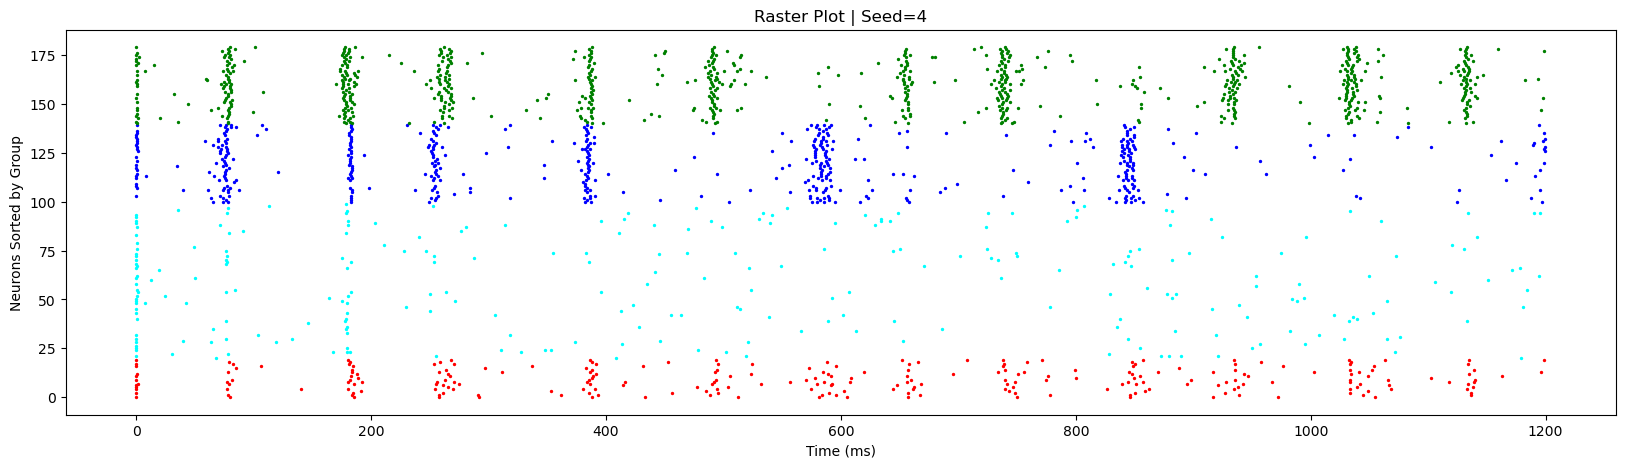

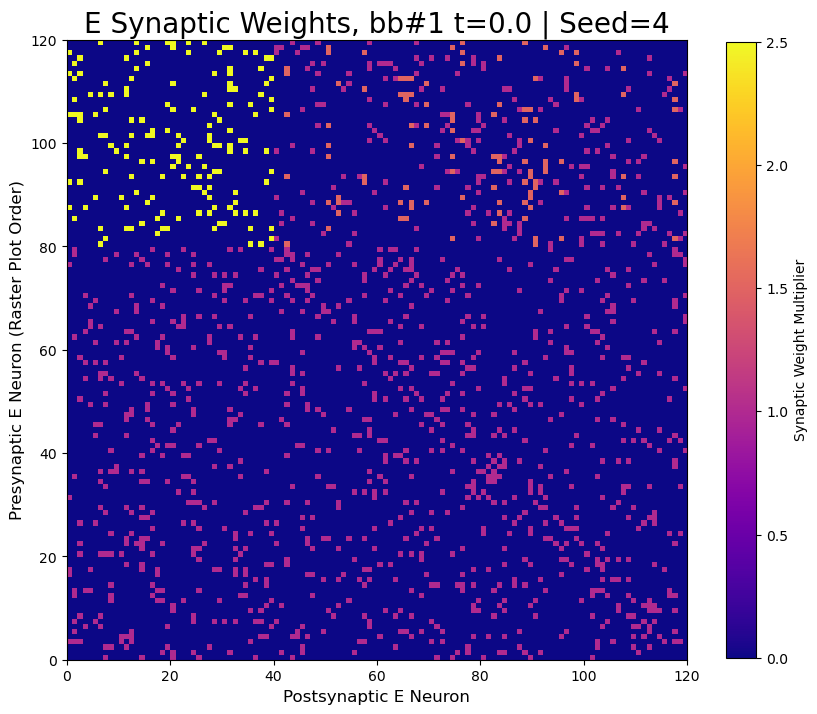

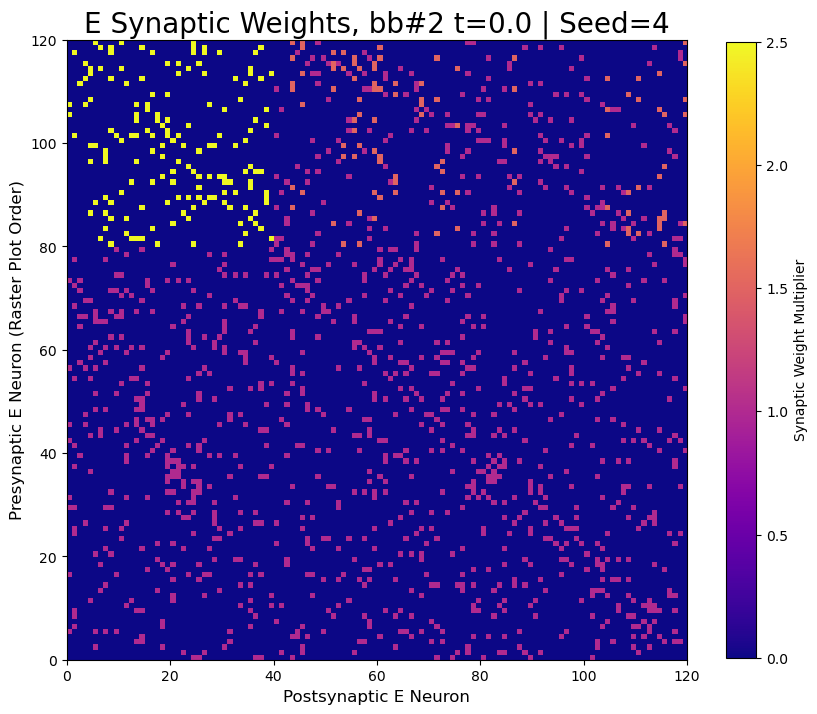

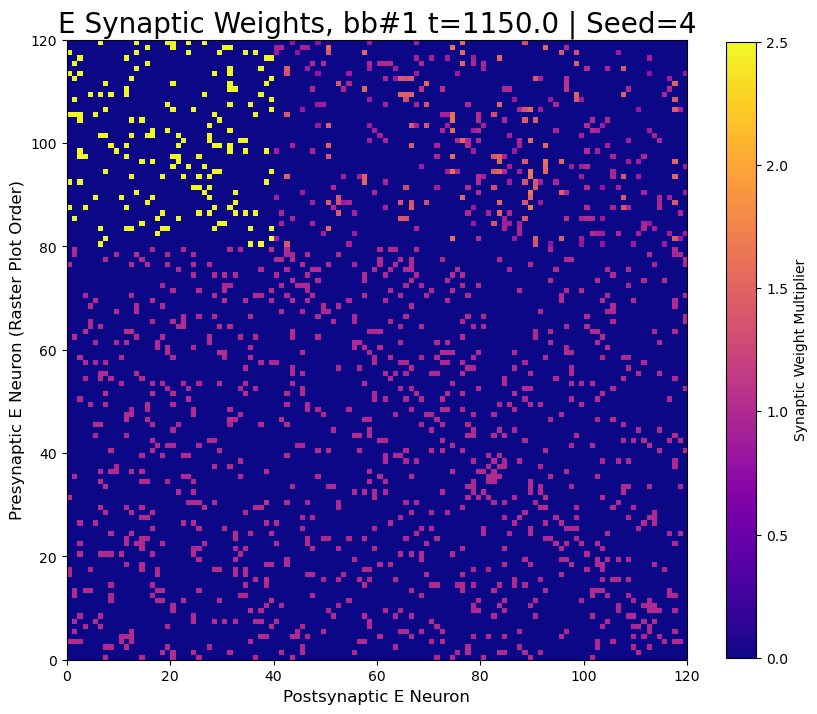

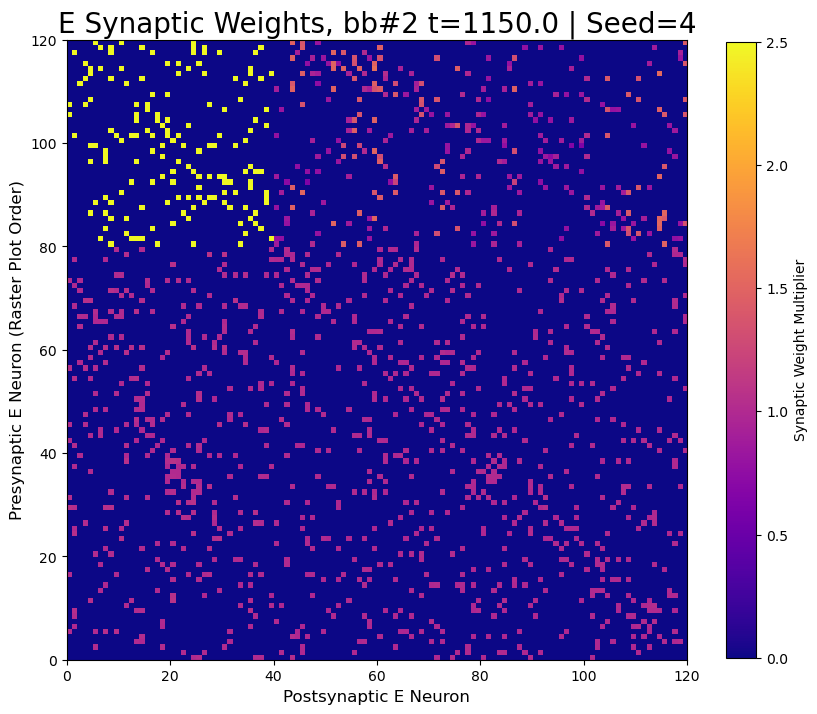

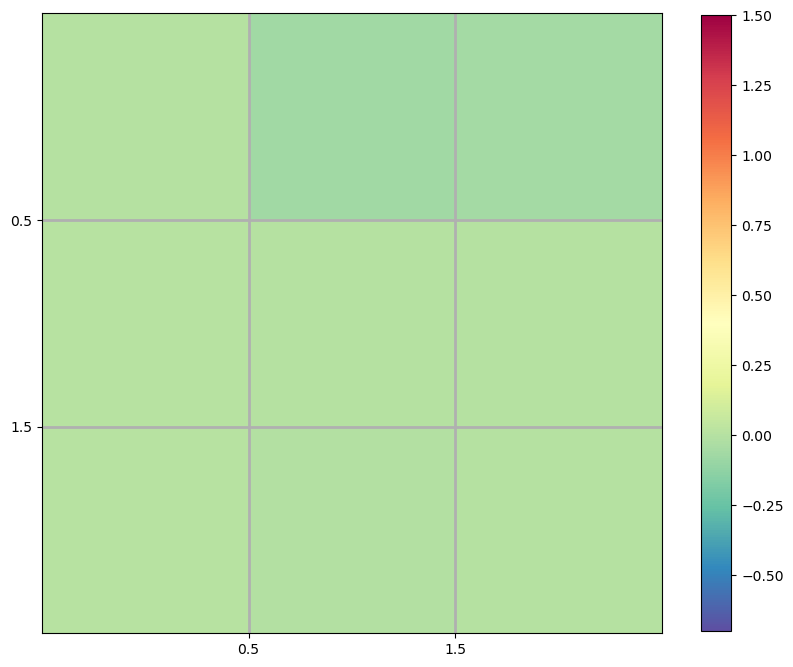

In [47]:
#plt.ioff() # Turns off interactive mode, meaning that plots are not automatically displayed. (this isn't working)
plot_singlesim_figs()
#plt.ion() # Turns it back on again.

In [38]:
for (name,val) in list(vars(s_vars.s_params[0]).items()):
    print(name,val)

numEquations 4
stepSize 0.1
simLength 6000
tarray [0.0000e+00 1.0000e-01 2.0000e-01 ... 5.9997e+03 5.9998e+03 5.9999e+03]
Ntimes 60000
spikeThreshold 5
numnrn 140
numSST 20
c_e 0.1
c_i 0.5
p_e 0.8
p_i 0
local_conn True
gks_NREM 1.5
gks_REM 0
gks_test 0.1
Idrive_min 0.5
Idrive_max 0.5
Idrive_SST -0.1
Idrive_LE -6
Idrive_NABB -6
w_max 100
NABP_boo False
makeSound True
plas_skip_time 0
NREMtest_boo False
RD_seed True
sim_seed 5
bbs_toplot [1]
directory C:/Users/micha/OneDrive - brandeis.edu/Umich Stuff/Zochowski Lab/Results/Figure 2/Data/REM single BB 2 LE groups/seed=5/
osc_period 500
num_test_phases 0
BB_len_test 0
BB_len_NREM 3000
BB_len_REM 0
t_start_NREM 0
t_start_NREMtest 6000
t_start_REM 6000
t_start_posttest 6000
storage_freq 50
w_EE 0.15
w_EI 0.08
w_II 0.15
w_IE 0
w_II_B 0
w_IE_B 0.05
LEtoBB_mult 1
LEtoLE_mult 1
LEtoSST_mult 1
BBtoLE_mult 1
SSTtoLE_mult 3.5
SSTtoBB_mult 0.5
A_dep 0.025
A_pot 0.07
tau_dep 34
tau_pot 14
const_ISI 30
LEtoLE_plas_mult 0.3
LEtoBB_plas_mult 0.3
bg_str 

In [40]:
for (name,val) in list(vars(s_vars.s_neurons[0][1]).items()):
    print(name,val)

ID 1
position []
connections [[  0.   1.]
 [  1.   0.]
 [  2.   0.]
 [  3.   0.]
 [  4.   0.]
 [  5.   0.]
 [  6.   0.]
 [  7.   0.]
 [  8.   1.]
 [  9.   0.]
 [ 10.   0.]
 [ 11.   1.]
 [ 12.   0.]
 [ 13.   0.]
 [ 14.   0.]
 [ 15.   0.]
 [ 16.   0.]
 [ 17.   0.]
 [ 18.   0.]
 [ 19.   0.]
 [ 20.   0.]
 [ 21.   0.]
 [ 22.   0.]
 [ 23.   0.]
 [ 24.   0.]
 [ 25.   0.]
 [ 26.   1.]
 [ 27.   0.]
 [ 28.   0.]
 [ 29.   0.]
 [ 30.   0.]
 [ 31.   0.]
 [ 32.   0.]
 [ 33.   0.]
 [ 34.   0.]
 [ 35.   1.]
 [ 36.   0.]
 [ 37.   0.]
 [ 38.   0.]
 [ 39.   0.]
 [ 40.   0.]
 [ 41.   0.]
 [ 42.   0.]
 [ 43.   0.]
 [ 44.   0.]
 [ 45.   0.]
 [ 46.   0.]
 [ 47.   0.]
 [ 48.   0.]
 [ 49.   0.]
 [ 50.   0.]
 [ 51.   0.]
 [ 52.   0.]
 [ 53.   0.]
 [ 54.   0.]
 [ 55.   0.]
 [ 56.   0.]
 [ 57.   0.]
 [ 58.   0.]
 [ 59.   0.]
 [ 60.   0.]
 [ 61.   1.]
 [ 62.   0.]
 [ 63.   0.]
 [ 64.   0.]
 [ 65.   0.]
 [ 66.   0.]
 [ 67.   0.]
 [ 68.   0.]
 [ 69.   0.]
 [ 70.   0.]
 [ 71.   0.]
 [ 72.   0.]
 [ 73.   1.]
 [ 74.   

In [70]:
# times = np.array([x[1] for x in s_vars.s_neurons[0][0].cw_out_history])
# print(abs(times-60))

print(s_vars.s_neurons[0][0].cw_out_history[2][0])

[1.         5.04755839 5.08712863 1.         1.         1.
 1.         4.95138038 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         4.97613343
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         5.12717786 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         2.5        1.         1.         1.         1.
 1.         2.5        1.         1.         1. 

In [ ]:
A = np.ones((3,3))
A[:,-1] = 2
B = np.sum(A[0:2,0:3])
print(A)
print(B)

for row_ind, row in enumerate(A):
    for col_ind, col in enumerate(row):
        print(row_ind,col_ind)